In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.tsa.seasonal import seasonal_decompose

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism_alemania.csv', sep=";", decimal=".", encoding="utf-8")
date_column = 'Fecha'
target_column = 'Alemania'

dataset[date_column] = pd.to_datetime(dataset[date_column])
dataset.rename(columns={f"Llegadas a AGP {target_column}": 'Llegadas a AGP'}, inplace=True)

dataset.head()

,Alemania,Pib Pc,IPC Armonizado,Desempleo Armonizado,Asientos ofertados,IPC España Armonizado,Llegadas a AGP,Mortalidad,Indice del consumidor,Búsquedas hacia AGP total,Búsquedas hacia AGP 3 meses,Búsquedas hacia AGP 6 meses,Fecha
0,76517.0,6770.0,84.3,11.5,-1,81.16,23662.0,73561,-13.7,0,0,0,2005-01-01
1,89108.0,6770.0,84.6,11.5,-1,81.35,26658.0,72275,-14.5,0,0,0,2005-02-01
2,113595.0,6770.0,84.9,11.5,-1,82.07,43621.0,83271,-15.2,0,0,0,2005-03-01
3,135801.0,6980.0,84.9,11.3,-1,83.24,47549.0,68245,-15.4,0,0,0,2005-04-01
4,181280.0,6980.0,85.2,11.3,-1,83.37,64567.0,69328,-14.7,0,0,0,2005-05-01


In [3]:
dataset['Mes'] = dataset[date_column].dt.month
dataset = dataset.set_index(dataset[date_column])
dataset = dataset.drop(columns=[date_column])
dataset

,Alemania,Pib Pc,IPC Armonizado,Desempleo Armonizado,Asientos ofertados,IPC España Armonizado,Llegadas a AGP,Mortalidad,Indice del consumidor,Búsquedas hacia AGP total,Búsquedas hacia AGP 3 meses,Búsquedas hacia AGP 6 meses,Mes
Fecha,,,,,,,,,,,,,
2005-01-01,76517.0,6770.0,84.3,11.5,-1,81.16,23662.0,73561,-13.7,0,0,0,1
2005-02-01,89108.0,6770.0,84.6,11.5,-1,81.35,26658.0,72275,-14.5,0,0,0,2
2005-03-01,113595.0,6770.0,84.9,11.5,-1,82.07,43621.0,83271,-15.2,0,0,0,3
2005-04-01,135801.0,6980.0,84.9,11.3,-1,83.24,47549.0,68245,-15.4,0,0,0,4
2005-05-01,181280.0,6980.0,85.2,11.3,-1,83.37,64567.0,69328,-14.7,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.0,12250.0,126.6,3.0,-1,120.03,52854.0,0,-14.0,0,0,0,8
2024-09-01,0.0,12250.0,126.6,3.0,-1,120.03,52854.0,0,-14.0,0,0,0,9
2024-10-01,0.0,12250.0,126.6,3.0,-1,120.03,52854.0,0,-14.0,0,0,0,10


In [4]:
start = '2005-01-01'
end = '2023-12-01'

def split_by_datetime(dataframe, start_date, end_date):
    """
    Given a pandas dataset and start date/end date, select a portion of this dataset
    
    Date format: 'yyyy-mm-dd'
    
    Returns a portion of the original dataset
    """
    mask = (dataframe.index>= start_date) & (dataframe.index <= end_date)
    dataframe = dataframe.loc[mask]
    return dataframe
    
# # En un primer momento vamos a trabajar con un rango de fechas que sabemos que no hay valores nulos o perturbados
dataset = split_by_datetime(dataset, start, end)
dataset.tail()

,Alemania,Pib Pc,IPC Armonizado,Desempleo Armonizado,Asientos ofertados,IPC España Armonizado,Llegadas a AGP,Mortalidad,Indice del consumidor,Búsquedas hacia AGP total,Búsquedas hacia AGP 3 meses,Búsquedas hacia AGP 6 meses,Mes
Fecha,,,,,,,,,,,,,
2023-08-01,128291.0,12250.0,127.2,3.0,98683,120.03,90666.0,0,-15.2,742798,681718,775824,8
2023-09-01,165641.0,12250.0,127.4,3.0,100466,120.03,94491.0,0,-15.9,652748,652748,726662,9
2023-10-01,114950.0,12250.0,127.2,3.0,97917,120.03,88607.0,0,-15.5,493620,539068,646514,10
2023-11-01,106165.0,12250.0,126.3,3.0,58505,120.03,47427.0,0,-16.5,321133,449919,596924,11
2023-12-01,0.0,12250.0,126.6,3.0,58216,120.03,52854.0,0,-14.0,145490,443113,580315,12


In [5]:
dataset.describe()

,Alemania,Pib Pc,IPC Armonizado,Desempleo Armonizado,Asientos ofertados,IPC España Armonizado,Llegadas a AGP,Mortalidad,Indice del consumidor,Búsquedas hacia AGP total,Búsquedas hacia AGP 3 meses,Búsquedas hacia AGP 6 meses,Mes
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,2.280000e+02,228.000000,2.280000e+02,228.000000
mean,123831.241228,9170.789474,99.918421,5.572368,46951.631579,99.481140,50304.254386,71155.557018,-6.621053,1.797405e+05,126916.820175,1.591635e+05,6.500000
std,57278.550014,1441.944138,10.156950,2.471009,31522.812307,8.938245,22202.434466,18621.222667,6.920900,3.294344e+05,243192.780448,2.981736e+05,3.459648
min,0.000000,6770.000000,84.300000,3.000000,-1.000000,81.160000,26.000000,0.000000,-29.400000,0.000000e+00,0.000000,0.000000e+00,1.000000
25%,83813.750000,7930.000000,92.000000,3.400000,21761.750000,93.122500,32334.750000,68559.000000,-10.625000,0.000000e+00,0.000000,0.000000e+00,3.750000
50%,128505.000000,8995.000000,99.200000,4.950000,48610.500000,100.190000,52609.500000,73288.500000,-4.650000,0.000000e+00,0.000000,0.000000e+00,6.500000
75%,164439.500000,10255.000000,105.225000,7.150000,71345.000000,103.870000,66967.750000,78486.250000,-0.800000,2.694005e+05,160831.500000,2.202055e+05,9.250000
max,258230.000000,12250.000000,127.400000,11.500000,103402.000000,120.130000,95772.000000,108792.000000,2.800000,1.179389e+06,888281.000000,1.081438e+06,12.000000


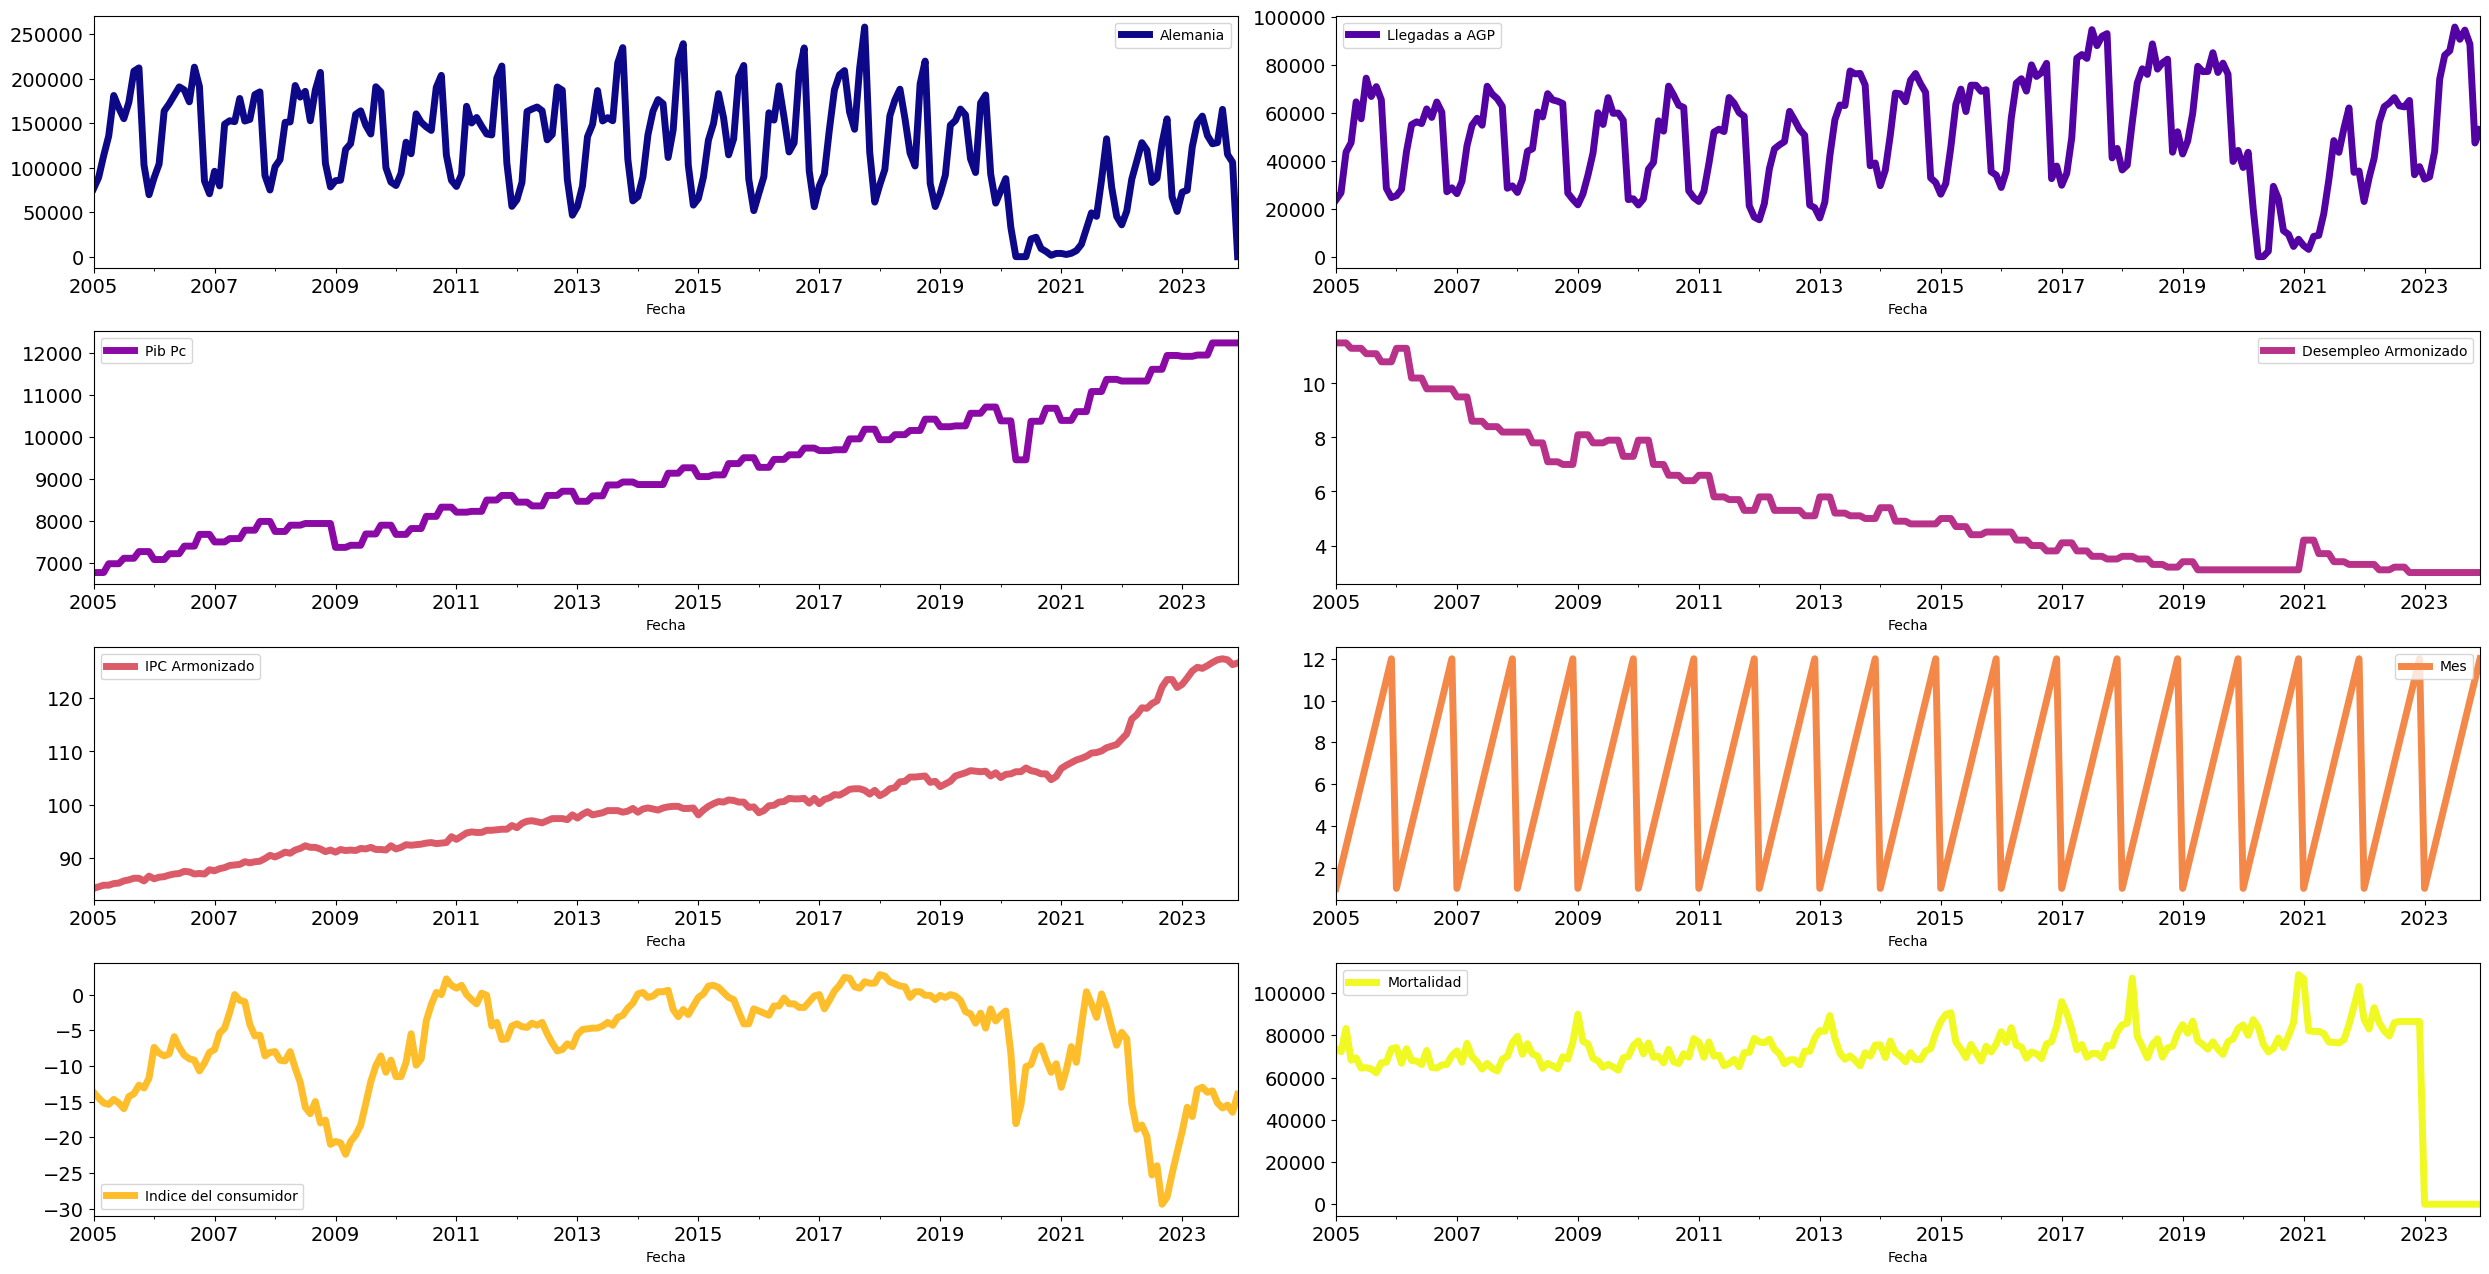

In [6]:
arrivals = dataset[[target_column,f'Llegadas a AGP','Pib Pc','Desempleo Armonizado',
                    'IPC Armonizado', 'Mes', 'Indice del consumidor', 'Mortalidad']] #'Asientos ofertados',

arrivals.plot(subplots=True,
    figsize=(25, 25),
    layout=(8, 2),
    sharex=False,
    sharey=False,
    colormap='plasma',
    fontsize=14,
    linewidth=5
)
plt.tight_layout()

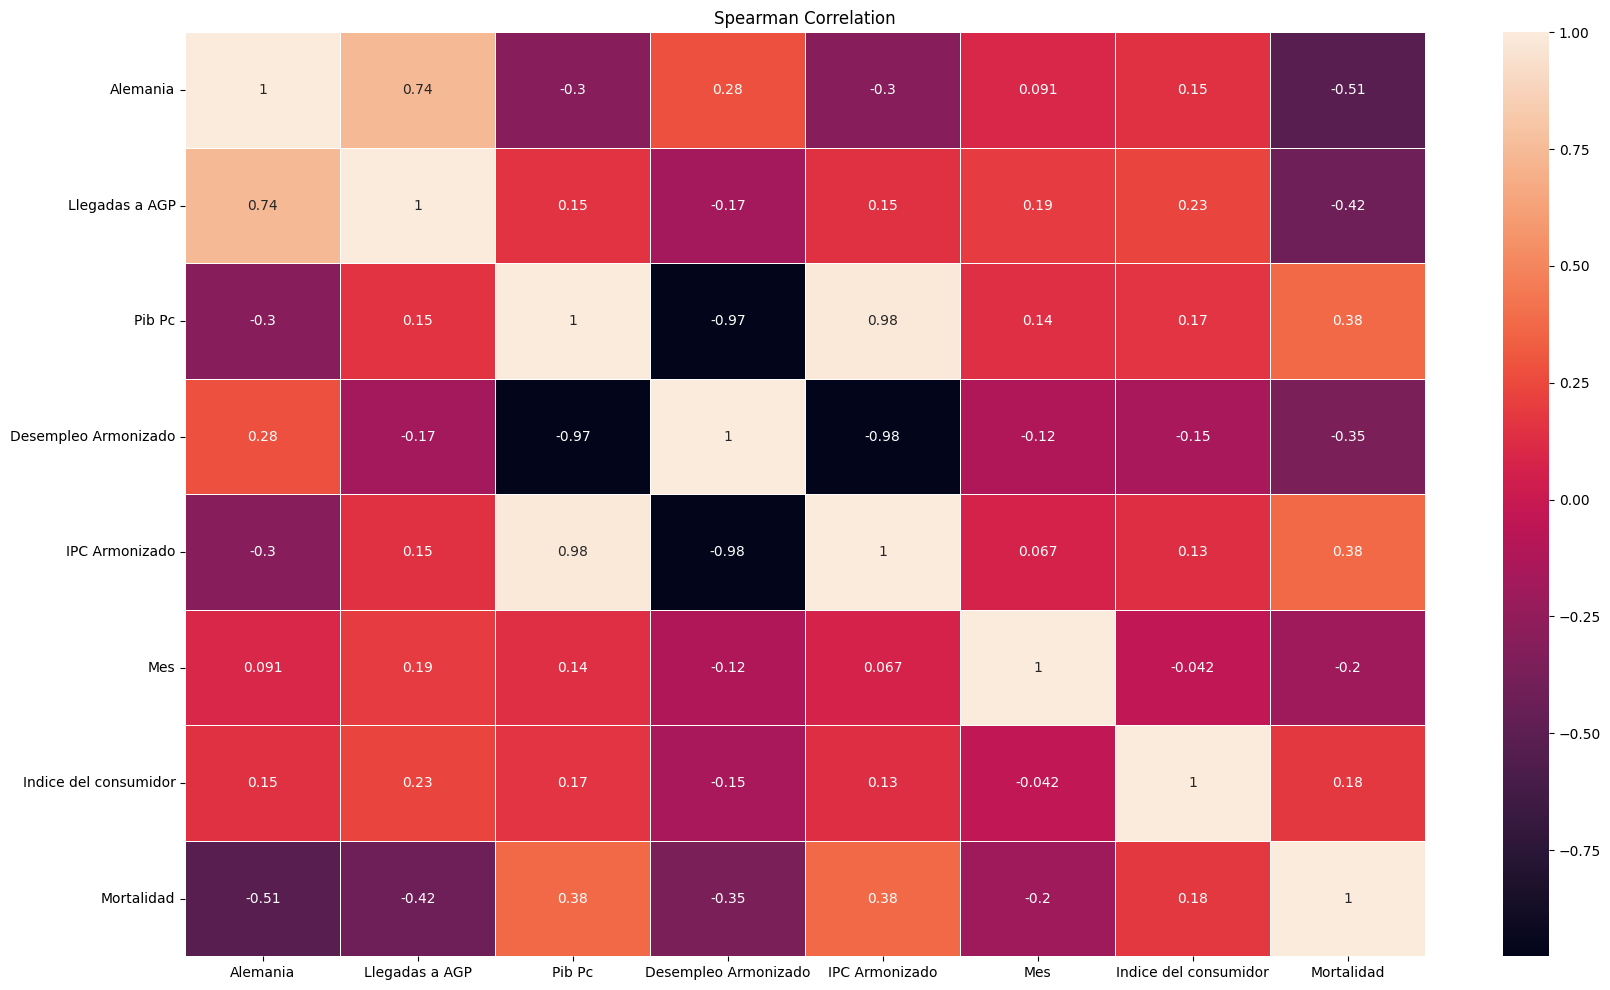

In [7]:
def display_correlation(df):
    plt.figure(figsize=(20,12))
    heatmap = sns.heatmap(df, annot=True, linewidths=0.4,
           annot_kws={'size': 10})
    plt.title("Spearman Correlation")

pearson_corr = arrivals.corr(method="spearman")

display_correlation(pearson_corr)

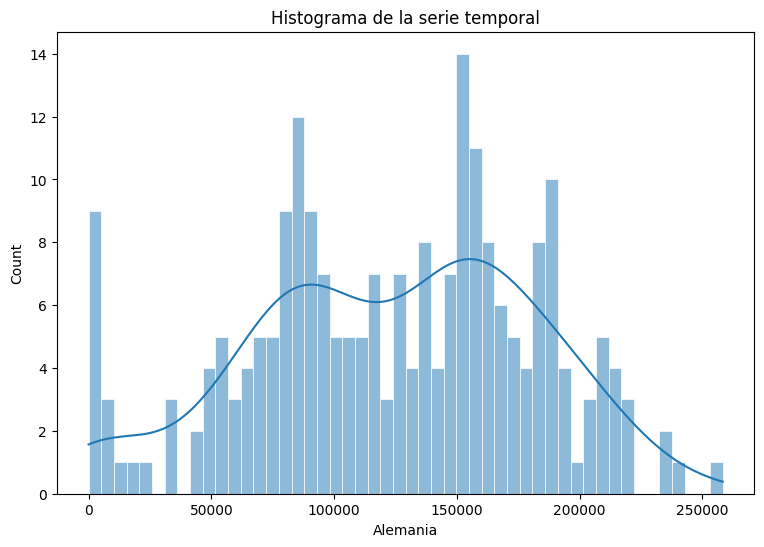

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(arrivals[target_column], kde=True, bins=50, linewidth=0.5, edgecolor= 'white', ax = ax)
ax.set_title('Histograma de la serie temporal')
fig.show()


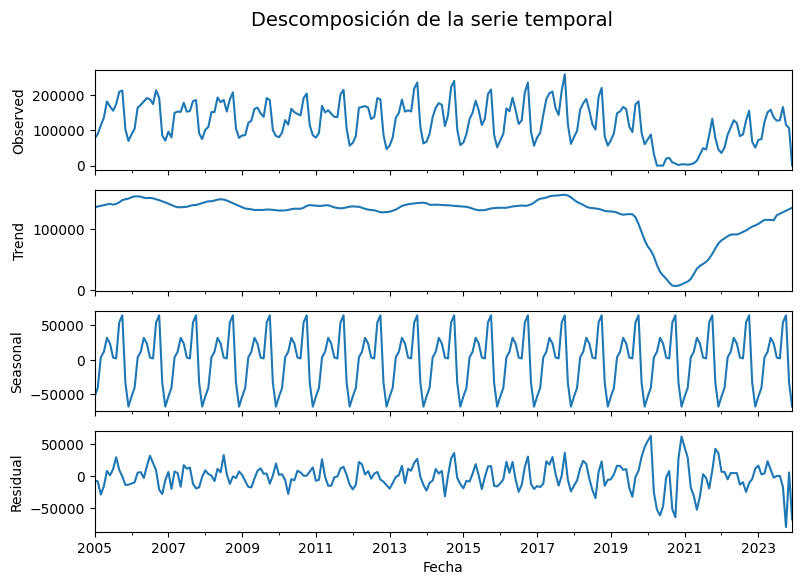

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)
res_decompose = seasonal_decompose(arrivals[target_column], model='additive', period=12, extrapolate_trend='freq')

res_decompose.observed.plot(ax=axs[0], legend=False)
axs[0].set_ylabel('Observed')
res_decompose.trend.plot(ax=axs[1], legend=False)
axs[1].set_ylabel('Trend')
res_decompose.seasonal.plot(ax=axs[2], legend=False)
axs[2].set_ylabel('Seasonal')
res_decompose.resid.plot(ax=axs[3], legend=False)
axs[3].set_ylabel('Residual')
fig.suptitle('Descomposición de la serie temporal', fontsize=14)
plt.show()

In [10]:
# from alibi_detect.utils.pytorch import DeepKernel
# from torch import nn
# from alibi_detect.cd import LearnedKernelDrift

# # define the projection phi
# proj = nn.Sequential(
#     nn.Conv2d(3, 8, 4, stride=2, padding=0),
#     nn.ReLU(),
#     nn.Conv2d(8, 16, 4, stride=2, padding=0),
#     nn.ReLU(),
#     nn.Conv2d(16, 32, 4, stride=2, padding=0),
#     nn.ReLU(),
#     nn.Flatten(),
# )

# # define the kernel
# kernel = DeepKernel(proj, eps=0.01)

# # instantiate the detector
# cd = LearnedKernelDrift(split_by_datetime(dataset, start, "2016-12-01").to_numpy(), kernel, backend='pytorch', p_val=.05, epochs=10, batch_size=32)

# data_drift = cd.predict(split_by_datetime(dataset, "2017-01-01", "2022-01-01").to_numpy(), return_p_val=True, return_distance=True)
# data_drift

## Feature engineering

In [11]:
# Crear características de lags
# for lag in range(1, 13):
#     arrivals[f'lag_{lag}'] = arrivals[target_column].shift(lag)

lag = 12
arrivals[f'lag_{lag}'] = arrivals[target_column].shift(lag)

# # # Crear características de ventanas móviles
for window in [12]:
    arrivals[f'rolling_mean_{window}'] = arrivals[target_column].rolling(window=window).mean()
    arrivals[f'rolling_std_{window}'] = arrivals[target_column].rolling(window=window).std()

# # Crear características de estacionalidad
# df['month'] = df.index.month
# df['quarter'] = df.index.quarter
# df['year'] = df.index.year

# Eliminar filas con valores NaN (resultantes de los lags y ventanas móviles)
arrivals = arrivals.dropna()

# # Dividir los datos en características (X) y etiquetas (y)
# X = df.drop(columns=['arrivals'])
# y = df['arrivals']

/tmp/ipykernel_3788154/4223613326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivals[f'lag_{lag}'] = arrivals[target_column].shift(lag)
/tmp/ipykernel_3788154/4223613326.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivals[f'rolling_mean_{window}'] = arrivals[target_column].rolling(window=window).mean()
/tmp/ipykernel_3788154/4223613326.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [12]:
arrivals.head(26)

,Alemania,Llegadas a AGP,Pib Pc,Desempleo Armonizado,IPC Armonizado,Mes,Indice del consumidor,Mortalidad,lag_12,rolling_mean_12,rolling_std_12
Fecha,,,,,,,,,,,
2006-01-01,88568.0,25446.0,7080.0,11.3,86.1,1,-7.4,74230,76517.0,141508.416667,48610.777231
2006-02-01,104246.0,28086.0,7080.0,11.3,86.4,2,-8.2,66793,89108.0,142769.916667,47306.228434
2006-03-01,163785.0,43915.0,7080.0,11.3,86.5,3,-8.6,73680,113595.0,146952.416667,46707.221580
2006-04-01,171910.0,55077.0,7220.0,10.2,86.8,4,-8.3,68105,135801.0,149961.500000,47085.108539
2006-05-01,181345.0,56241.0,7220.0,10.2,87.0,5,-5.9,67837,181280.0,149966.916667,47089.042525
2006-06-01,190968.0,55526.0,7220.0,10.2,87.1,6,-7.4,66177,167303.0,151939.000000,48359.484246
2006-07-01,187489.0,61640.0,7400.0,9.8,87.5,7,-8.5,72864,155166.0,154632.583333,49443.596110
2006-08-01,174139.0,58086.0,7400.0,9.8,87.4,8,-9.0,64777,173698.0,154669.333333,49459.216561
2006-09-01,213117.0,64518.0,7400.0,9.8,87.0,9,-9.2,64502,208641.0,155042.333333,49918.000505


In [13]:
dataset_train = split_by_datetime(arrivals,'2009-01-01','2016-12-01')
dataset_test = split_by_datetime(arrivals,'2017-01-01','2017-12-01')
dataset_val = split_by_datetime(arrivals,'2018-01-01', dataset.index[-1])

In [14]:
dataset_train.shape

(96, 11)

In [15]:
dataset_test.shape

(12, 11)

In [16]:
dataset_val.shape

(72, 11)

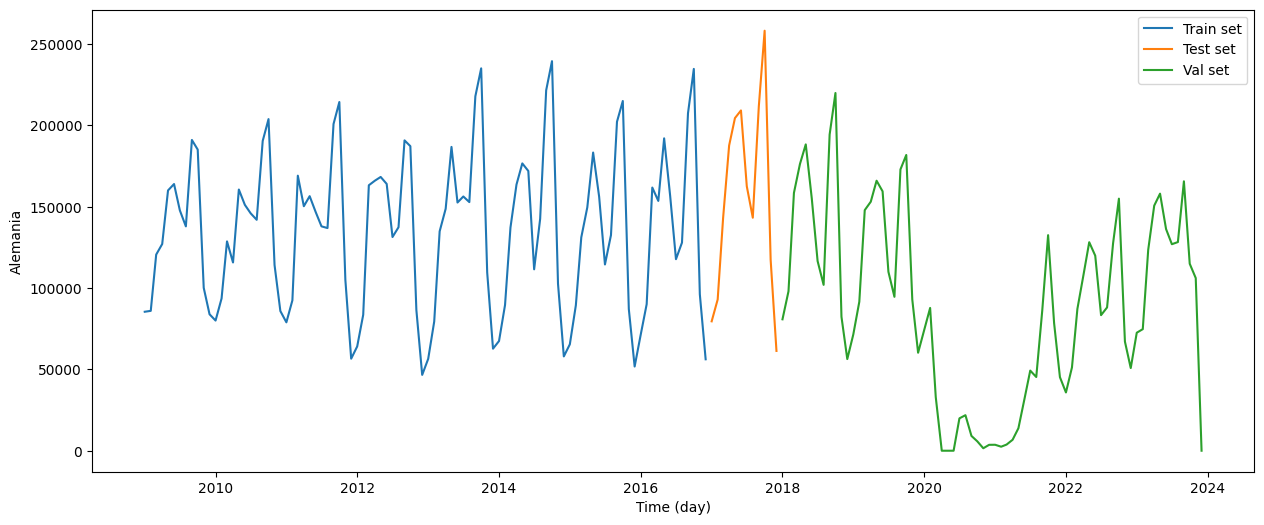

In [17]:
# Plot train and test data
plt.figure(figsize = (15, 6))
plt.plot(dataset_train[target_column])
plt.plot(dataset_test[target_column])
plt.plot(dataset_val[target_column])
plt.xlabel('Time (day)')
plt.ylabel(target_column)
plt.legend(['Train set', 'Test set', 'Val set'], loc='upper right')

In [18]:
import numpy as np
y_train = np.array(dataset_train[target_column])
# Remove the labels from the features
X_train = dataset_train.drop(target_column, axis = 1)
# Saving feature names for later use
feature_list = list(dataset_train.columns)
print(X_train.shape)
print(y_train.shape)

(96, 10)
(96,)


In [19]:
# Labels are the values we want to predic
y_test = np.array(dataset_test[target_column])
# Remove the labels from the features
X_test = dataset_test.drop(target_column, axis = 1)
# Convert to numpy array
# X_test = np.array(dataset_test)
X_test.shape

(12, 10)

In [20]:
# Labels are the values we want to predict
y_val = np.array(dataset_val[target_column])
# Remove the labels from the features
X_val = dataset_val.drop(target_column, axis = 1)
# Convert to numpy array
X_val.shape

(72, 10)

## Train a model

In [21]:
# Verificar si hay valores NaN en los datos
print(f'NaN en X: {X_train.isna().sum().sum()}')
print(f'NaN en y: {np.isnan(y_train).sum()}')

NaN en X: 0
NaN en y: 0


In [22]:
def results_search(search):
    # Obtener los resultados de cada iteración del RandomizedSearchCV
    cv_results = search.cv_results_
    
    # Convierte los resultados a un DataFrame para análisis
    results_df = pd.DataFrame(cv_results)
    
    # Selecciona las columnas relevantes
    results_df = results_df[['mean_test_score', 'std_test_score', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'rank_test_score']]
    
    # Ordena por el rango de la puntuación de la prueba
    results_df = results_df.sort_values(by='rank_test_score')
    
    print("Resultados del SearchCV:")
    print(results_df)

Resultados del SearchCV:
     mean_test_score  std_test_score param_n_estimators param_max_features  \
144    -12470.784930     4056.584272                 59                 10   
187    -12652.310395     4900.395301                168                 10   
121    -12677.163249     6179.357088                171                 10   
156    -12681.182048     3060.073617                 87                 10   
177    -12731.743728     2780.853198                 79                 10   
..               ...             ...                ...                ...   
94     -19468.636483     3977.942977                110                 10   
165    -20118.196413     2287.249791                 80                 10   
172    -20301.234523     3450.500208                 74                 10   
42     -20905.633669     4755.767542                142                 10   
6      -29010.926481     2800.278741                 58                 10   

    param_max_depth param_min_samples_

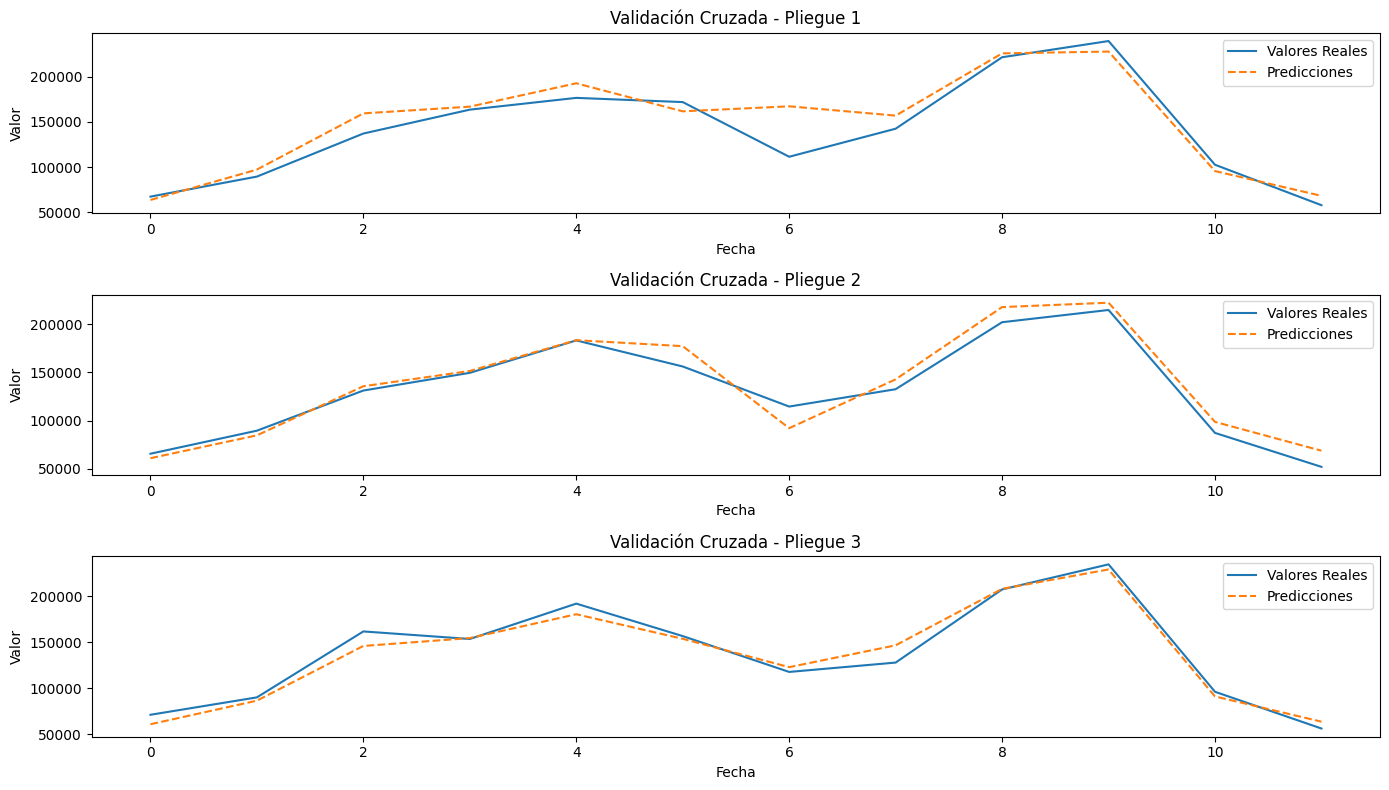

Resultados de la validación cruzada:
            MSE        R2           MAE
0  3.814461e+08  0.873652  13910.409529
1  1.539456e+08  0.939162  10136.389685
2  8.355110e+07  0.970491   7317.900772
Test MSE: 563204154.8919544
Test R2: 0.8326178894275194
Test MAE: 18627.00726948209
Mejores hiperparámetros: {'learning_rate': 0.07412843843190285, 'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 59, 'subsample': 0.8194412471752612}


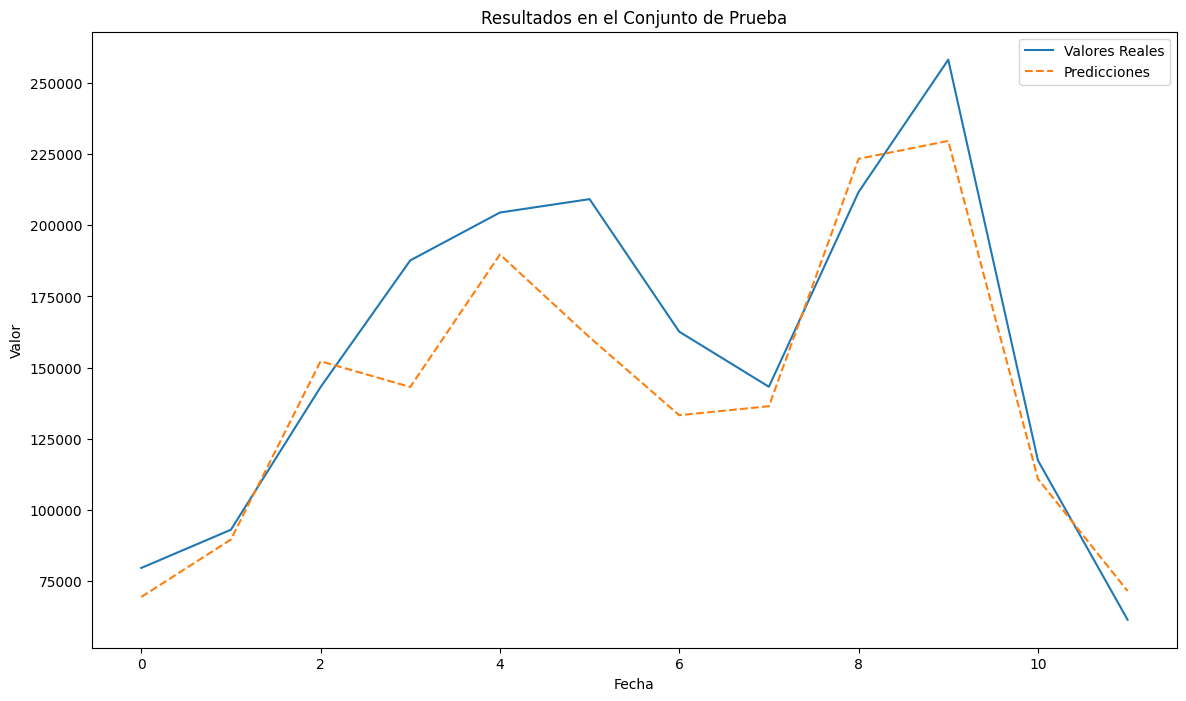

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error, make_scorer
from scipy.stats import randint,uniform
import matplotlib.pyplot as plt

# Plotea los resultados de la validación cruzada
plt.figure(figsize=(14, 8))

# Crea el objeto TimeSeriesSplit
test_size = 12  
n_splits = 3 
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# # Parámetros a buscar
# param_distributions = {
#     'n_estimators':  randint(600, 1500),
#     'max_features': [X_test.shape[1]],
#     'max_depth': [3,5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#     'min_samples_split': randint(2, 5),
#     'min_samples_leaf': randint(1, 3)
# }

param_distributions = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'max_features': [X_test.shape[1]]
}

# Modelo base
rf_model = GradientBoostingRegressor()

# Definir una métrica de evaluación personalizada (si se desea)
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


# Modelo base
# rf_model = RandomForestRegressor()

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=200,
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    return_train_score=True,
    scoring=scorer
)

# Entrena la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = random_search.best_estimator_
# Visualiza los resultados en una tabla
results_search(random_search)

# Score de Search
print("SCORE SEARCH")
print(best_model.score)

# Resultados de la validación cruzada
results = []
for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_val_fold.index[0])
    # Entrena el modelo con los mejores parámetros
    best_model.fit(X_train_fold, y_train_fold)

    # Realiza predicciones
    y_val_pred = best_model.predict(X_val_fold)

    # Calcula las métricas
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    mae = mean_absolute_error(y_val_fold, y_val_pred)

    # Guarda los resultados
    results.append({'MSE': mse, 'R2': r2, 'MAE': mae})
     
    # Plot
    plt.subplot(n_splits, 1, i + 1)
    plt.plot(pd.Series(y_val_fold).index, y_val_fold, label='Valores Reales')
    plt.plot(pd.Series(y_val_fold).index, y_val_pred, label='Predicciones', linestyle='--')
    plt.title(f'Validación Cruzada - Pliegue {i + 1}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()

plt.tight_layout()
plt.show()


# Convierte los resultados a un DataFrame para análisis
results_df = pd.DataFrame(results)
print("Resultados de la validación cruzada:")
print(results_df)

# Finalmente, evalúa el modelo en el conjunto de prueba
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Calcula las métricas en el conjunto de prueba
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
print(f"Test MAE: {test_mae}")

print(f"Mejores hiperparámetros: {random_search.best_params_}")

# Plotea los resultados en el conjunto de prueba
plt.figure(figsize=(14, 8))
plt.plot(pd.Series(y_test).index, y_test, label='Valores Reales')
plt.plot(pd.Series(y_test).index, y_test_pred, label='Predicciones', linestyle='--')
plt.title('Resultados en el Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


## Grid Search

In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def rf_grid_search(
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        y_test: pd.Series,
        param_distributions: dict,
        test_size: int = 12,
        n_splits: int = 5,
        n_jobs: int = -1
):
    """
    Function to perform time series modeling with RandomForestRegressor and hyperparameter tuning.

    Parameters:
    X_train (pd.DataFrame): Training features
    y_train (pd.Series): Training target
    X_test (pd.DataFrame): Test features
    y_test (pd.Series): Test target
    param_distributions (dict): Hyperparameter grid for GridSearchCV
    test_size (int): Size of the test set for TimeSeriesSplit
    n_splits (int): Number of splits for TimeSeriesSplit
    n_jobs (int): Number of jobs to run in parallel for GridSearchCV

    Returns:
    pd.DataFrame: Cross-validation results
    dict: Best hyperparameters found
    dict: Test set evaluation metrics
    """
    
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

    # Base model
    rf_model = GradientBoostingRegressor()

    # Hyperparameter search with GridSearchCV
    gd_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_distributions,
        cv=tscv,
        n_jobs=n_jobs
    )

    # Train the hyperparameter search
    gd_search.fit(X_train, y_train)

    # Best model found
    gd_best_model = gd_search.best_estimator_

    # Print best model score
    print(f"Best model score: {gd_best_model.score(X_train, y_train)}")

    # Cross-validation results
    results = []
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        print(f"Validation start date: {X_val_fold.index[0]}")
        
        # Train the model with the best parameters
        gd_best_model.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_val_pred = gd_best_model.predict(X_val_fold)

        # Calculate metrics
        mse = mean_squared_error(y_val_fold, y_val_pred)
        r2 = r2_score(y_val_fold, y_val_pred)
        mae = mean_absolute_error(y_val_fold, y_val_pred)

        # Store results
        results.append({'MSE': mse, 'R2': r2, 'MAE': mae})

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    print("Cross-validation results:")
    print(results_df)

    # Final evaluation on test set
    gd_best_model.fit(X_train, y_train)
    y_test_pred = gd_best_model.predict(X_test)

    # Calculate test set metrics
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    test_metrics = {
        'Test MSE': test_mse,
        'Test R2': test_r2,
        'Test MAE': test_mae
    }
    
    print(f"Test MSE: {test_mse}")
    print(f"Test R2: {test_r2}")
    print(f"Test MAE: {test_mae}")
    print(f"Best hyperparameters: {gd_search.best_params_}")

    return results_df, gd_best_model, gd_search.best_params_, test_metrics

In [82]:
# Divide los datos en conjuntos de entrenamiento y prueba
test_size = 12  # 1 año de datos mensuales

# Crea el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=test_size)

# Parámetros a buscar
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 600, 1000],
    'max_features': [X_test.shape[1], 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [2, 5, 10],
    'random_state': [11]
}

results_df, best_model, best_params, test_metrics = rf_grid_search(X_train, pd.Series(y_train), X_test, pd.Series(y_test), param_distributions)

print(test_metrics)
results_df


/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9972365137710455
Validation start date: 2012-01-01 00:00:00
Validation start date: 2013-01-01 00:00:00
Validation start date: 2014-01-01 00:00:00
Validation start date: 2015-01-01 00:00:00
Validation start date: 2016-01-01 00:00:00
Cross-validation results:
            MSE        R2           MAE
0  2.395881e+08  0.894783  11927.829404
1  7.152745e+08  0.758280  20763.137908
2  4.555706e+08  0.849099  16154.484517
3  1.966236e+08  0.922296  12225.026537
4  1.737100e+08  0.938649  11200.291695
Test MSE: 797904990.7290128
Test R2: 0.7628657029169839
Test MAE: 21579.805393678816
Best hyperparameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 11}
{'Test MSE': 797904990.7290128, 'Test R2': 0.7628657029169839, 'Test MAE': 21579.805393678816}


,MSE,R2,MAE
0,2.395881e+08,0.894783,11927.829404
1,7.152745e+08,0.758280,20763.137908
2,4.555706e+08,0.849099,16154.484517
3,1.966236e+08,0.922296,12225.026537
4,1.737100e+08,0.938649,11200.291695


## Predict with Explainability

In [83]:
from sklearn.base import is_classifier, is_regressor
from sklearn.metrics import f1_score, recall_score, accuracy_score

def predict_xai(
        model: object,
        explainer: shap.Explainer,
        train_data: pd.DataFrame,
        test_data: pd.DataFrame,
        target_data: np.ndarray
):
        """
        Given a model, its explainer and the train and test data, this function returns the predictions and SHAP values associated to each feature by month

        Args:
                - model (object): the model to be explained
                - explainer (shap.Explainer): the explainer object
                - train_data (pd.DataFrame): the training data
                - test_data (pd.DataFrame): the test data
                - target_data (np.ndarray): the target column
        
        Returns:
                - predictions (np.array): the predictions of the model
                - measures (dict): The measures of the model
                - shap_values (shap.Explanation): the SHAP values of the model
        """
        # Get the predictions
        predictions = model.predict(test_data)

        measures = {}
        # Check if the model is a classifier or a regressor
        if is_classifier(model):
                measures = {
                        'ACC': accuracy_score(target_data, predictions),
                        'F1': f1_score(target_data, predictions),
                        'RECALL': recall_score(target_data, predictions)
                }
                #     print(measures)
        elif is_regressor(model):
                measures = {
                        'R2': r2_score(target_data, predictions),
                        'MSE': mean_squared_error(target_data, predictions),
                        'MAE': mean_absolute_error(target_data, predictions)
                }
                # print(measures)
        else:
                raise ValueError("Model not supported. The model is not a classifier nor a regressor")

        # Get the training SHAP values
        train_shap_values = explainer.shap_values(train_data)
        # Get the test SHAP values
        print(test_data.shape)
        test_shap_values = explainer.shap_values(test_data)

        xai_feat_month = {}
        for i, col in enumerate(test_data.columns):
                xai_feat_month[col] = {}
                min_prev = min(val[i] for val in train_shap_values)
                max_prev = max(val[i] for val in train_shap_values)
                min_test = min(val[i] for val in test_shap_values)
                max_test = max(val[i] for val in test_shap_values)
                for j, val in enumerate(test_shap_values):
                        train_val_norm = (train_shap_values[j][i] - min_prev) / (max_prev - min_prev)
                        test_val_norm = (val[i] - min_test) / (max_test - min_test)

                        xai_feat_month[col][j+1] = {
                                'prev': train_val_norm,
                                'test': test_val_norm
                        }
        
        return predictions, measures, xai_feat_month

## Re entrenamiento cuando se detecta drift

In [84]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import minkowski

def drift_on_explain_month(
        xais: pd.DataFrame
):
        """
                Calculate drift using Kolmogorov-Smirnov test on the SHAP values by feature and month
                Args:
                        - xais (pandas.DataFrame): Dataframe containing the month of the SHAP value, the feature asociated and the values for the training set and the prediction set.
                Returns:
                        - result (pandas.DataFrame): DataFrame containing the feature and the result of the test, divided by months.
        """
        months = xais.index.month.unique().tolist()
        rows = []

        for month in months:
                xais_month = xais[xais.index.month == month]
                ks_month_pval, ks_month_stat = ks_2samp(xais_month['Previous'], xais_month['Test'])
                for feat in xais_month['Feature']:
                        xais_feat = xais_month[xais_month['Feature'] == feat]
                        minkowski_distance = minkowski(xais_feat['Previous'].tolist(), xais_feat['Test'].tolist())
                        rows.append([feat, month, ks_month_pval, ks_month_stat, minkowski_distance])

        return pd.DataFrame(rows, columns=['Feature', 'Month', 'P-value', 'Statistic', 'Distance'])

def drift_detection (
        pvalues: dict,
        diff_pvalues: dict,
        distances: dict,
        year: int,
        max_pvalue: float = 0.05,
        max_distance: float = 0.85,
        max_diff_pvalue: float = -0.35,
        max_diff_distance: float = 0.35,
        n_violations_permitted: int = 6 # Knowing that the seasonality is 12. 6 would be half, 0 will detect if any max_pvalue or max_distance is overpassed and 12 will detect if all overpass it
) -> tuple[bool, dict]:
        """
                Drift detection based on pvalues of distribution and distances between explained features of a model
                Args:
                        - pvalues (dict): Dictionary containing the pvalues of the model by year
                        - diff_pvalues (dict): Dictionary containing the difference of pvalues of the model by year and month
                        - distances (dict): Dictionary containing the distances and the difference between them by year, month and feature
                        - year (int): Year to be analyzed
                        - max_pvalue (float): Maximum pvalue allowed
                        - max_distance (float): Maximum distance allowed
                        - max_diff_pvalue (float): Maximum difference of pvalue allowed
                        - max_diff_distance (float): Maximum difference of distance allowed
                        - n_violations_permited (int): Number of violations permited to consider that there is drift
                Returns:
                        - drift_detected (bool): True if drift is detected, False otherwise
        """
        direct_pvalue_comparison = [pvalue < max_pvalue for pvalue in pvalues[year]]
        diff_pvalue_comparison = [diff_pvalue < max_diff_pvalue for diff_pvalue in diff_pvalues]
        
        direct_distance_comparison = {}
        for month in distances[year].keys():
                direct_distance_comparison[month] = [feat for feat in distances[year][month].keys() if distances[year][month][feat]['distance'] > max_distance]

        diff_distance_comparison = {}
        for month in distances[year].keys():
                diff_distance_comparison[month] = [feat for feat in distances[year][month].keys() if distances[year][month][feat]['diff_year_prev'] > max_diff_distance]
        
        n_total = len(direct_pvalue_comparison)
        if n_total != len(direct_distance_comparison):
                raise ValueError("The number of pvalues and distances is different")
        elif n_violations_permitted > n_total or n_violations_permitted < 0:
                raise ValueError(f"The number of violations permited is not valid. Must be between 0 and {n_total}")
        
        drift_detected = (sum(direct_pvalue_comparison) >= n_violations_permitted or any(len(direct_distance_comparison[month]) > 0 for month in direct_distance_comparison) >= n_violations_permitted or (any(diff_pvalue_comparison) and any(len(diff_distance_comparison[month]) > 0 for month in diff_distance_comparison)))
        
        drift_details = {
                "direct_pvalue_violations": [i for i, violated in enumerate(direct_pvalue_comparison) if violated],
                "direct_distance_violations": {int(month): feats for month, feats in direct_distance_comparison.items() if feats},
                "diff_pvalue_violations": [i for i, violated in enumerate(diff_pvalue_comparison) if violated],
                "diff_distance_violations": {int(month): feats for month, feats in diff_distance_comparison.items() if feats}
        }
        
        
        return drift_detected, drift_details



In [85]:
def detect_drift_and_retrain(
    model,
    explainer,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    param_distributions,
    max_pvalue=0.05,
    max_distance=0.9,
    max_diff_dist=0.35,
    max_diff_pval=-0.35,
):
    preds, measures, xais = {}, {}, {}
    pvalues, distances, details = {}, {}, {}
    retrains = []

    years = X_val.index.year.unique().tolist()
    year_prev = years[0]

    best_model = model
    best_params = None
    test_metrics = None

    for year in years:
        print(year)
        X_val_year = X_val[X_val.index.year == year]
        y_val_year = y_val[X_val.index.year == year]

        preds[year], measures[year], xais[year] = predict_xai(
            model=model,
            explainer=explainer,
            train_data=X_train,
            test_data=X_val_year,
            target_data=y_val_year,
        )

        feats, rows = [], []
        for yyyy, xai_feat in xais.items():
            if yyyy == year:
                for feat, month in xai_feat.items():
                    for mm, val in month.items():
                        feats.append(pd.to_datetime(f"{yyyy}-{mm}", format="%Y-%m"))
                        rows.append([feat, val["prev"], val["test"]])

        xai_df = pd.DataFrame(
            rows, index=feats, columns=["Feature", "Previous", "Test"]
        )

        drift = drift_on_explain_month(xai_df)
        pvalues[year] = drift.groupby("Month")["P-value"].mean().to_list()

        diff_pvalues = [
            pvalues[year][i] - pvalues[year_prev][i] for i in range(len(pvalues[year]))
        ]
        distances[year] = {}
        for month in drift["Month"].unique():
            distances[year][month] = {}
            for feat in drift["Feature"].unique():
                distance_month_feat = drift[
                    (drift["Month"] == month) & (drift["Feature"] == feat)
                ]["Distance"].values[0]
                distances[year][month][feat] = {
                    "distance": distance_month_feat,
                    "diff_year_prev": (
                        distance_month_feat
                        - distances[year_prev][month][feat]["distance"]
                        if year != year_prev
                        else 0
                    ),
                }

        print(measures[year])
        has_drift, drift_details = drift_detection(
            pvalues=pvalues,
            diff_pvalues=diff_pvalues,
            distances=distances,
            year=year,
            max_pvalue=max_pvalue,
            max_distance=max_distance,
            max_diff_pvalue=max_diff_pval,
            max_diff_distance=max_diff_dist,
            n_violations_permitted=6,
        )

        if has_drift:
            print(f"Drift detected in year {year}")
            print("Drifting in:")
            print(drift_details)
            print("Retraining the model...")
            details[year] = drift_details

            new_X_train = pd.concat([X_train, X_val[X_val.index.year <= year]])
            new_y_train = np.concatenate([y_train, y_val[X_val.index.year <= year]])

            results, new_best_model, new_best_params, new_test_metrics = rf_grid_search(
                new_X_train,
                pd.Series(new_y_train),
                X_test,
                pd.Series(y_test),
                param_distributions,
            )

            model = new_best_model
            explainer = shap.TreeExplainer(model, new_X_train)

            best_model = new_best_model
            best_params = new_best_params
            test_metrics = new_test_metrics

            retrains.append(year)
        else:
            print(f"No drift detected in year {year}")

    return (
        preds,
        measures,
        xais,
        pvalues,
        distances,
        details,
        retrains,
        best_model,
        best_params,
        test_metrics,
    )


In [86]:
max_pvalue = 0.05
max_distance = 0.9
max_diff_dist = 0.25
max_diff_pval = -0.25

mymodel = best_model
(
    preds,
    measures,
    xais,
    pvalues,
    distances,
    details,
    retrains,
    best_model_after,
    best_params_after,
    test_metrics_after,
) = detect_drift_and_retrain(
    model = mymodel,
    explainer = shap.TreeExplainer(mymodel, X_train),
    X_train = X_train,
    y_train = y_train,
    X_val = X_val,
    y_val = y_val,
    X_test = X_test,
    y_test = y_test,
    param_distributions = param_distributions,
    max_pvalue = max_pvalue,
    max_distance = max_distance,
    max_diff_dist = max_diff_dist,
    max_diff_pval = max_diff_pval
)


2018
(12, 10)
{'R2': 0.7195634147187484, 'MSE': 722832580.4002215, 'MAE': 19055.241702589436}
No drift detected in year 2018
2019
(12, 10)
{'R2': 0.7485970668990192, 'MSE': 420209282.3474327, 'MAE': 16662.387747506647}
No drift detected in year 2019
2020
(12, 10)
{'R2': -13.704722652260477, 'MSE': 11999466696.096031, 'MAE': 94485.50253529115}
Drift detected in year 2020
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {3: ['IPC Armonizado', 'rolling_mean_12'], 12: ['Desempleo Armonizado']}, 'diff_pvalue_violations': [8], 'diff_distance_violations': {1: ['Llegadas a AGP', 'Pib Pc', 'Indice del consumidor'], 2: ['Llegadas a AGP', 'Pib Pc', 'Indice del consumidor'], 3: ['IPC Armonizado', 'Mes', 'rolling_mean_12'], 4: ['Mes', 'rolling_mean_12'], 6: ['Mes', 'Mortalidad'], 7: ['Llegadas a AGP', 'Mortalidad', 'lag_12'], 8: ['Mortalidad', 'lag_12'], 9: ['Desempleo Armonizado', 'Mortalidad'], 11: ['Desempleo Armonizado', 'Mortalidad'], 12: ['IPC Armonizado']}}
Retrain

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.996420768975851
Validation start date: 2015-01-01 00:00:00
Validation start date: 2016-01-01 00:00:00
Validation start date: 2018-01-01 00:00:00
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Cross-validation results:
            MSE        R2           MAE
0  2.160873e+08  0.914605  11991.346266
1  3.075977e+08  0.891362  12594.677888
2  6.155308e+08  0.761193  19408.380241
3  3.413039e+08  0.795805  15095.697978
4  7.918271e+09 -8.703430  77464.626996
Test MSE: 900453735.1492289
Test R2: 0.7323886101460568
Test MAE: 24579.18830909743
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 11}
2021
(12, 10)
{'R2': 0.7099159329401233, 'MSE': 439957433.482811, 'MAE': 17679.46600495504}
Drift detected in year 2021
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {5: ['Desempleo Armonizado']}, 'diff_pvalue_violat

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9974026497299936
Validation start date: 2016-01-01 00:00:00
Validation start date: 2018-01-01 00:00:00
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Validation start date: 2021-01-01 00:00:00
Cross-validation results:
            MSE        R2           MAE
0  3.075977e+08  0.891362  12594.677888
1  6.155308e+08  0.761193  19408.380241
2  3.413039e+08  0.795805  15095.697978
3  7.918271e+09 -8.703430  77464.626996
4  4.399574e+08  0.709916  17679.466005
Test MSE: 1021368104.5309788
Test R2: 0.696453324211349
Test MAE: 25695.824320046737
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 11}
2022
(12, 10)
{'R2': 0.012217578444700616, 'MSE': 1220072022.3843615, 'MAE': 30021.725303855997}
Drift detected in year 2022
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {1: ['Indice del consumidor'], 2: ['Indice 

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9968005621671948
Validation start date: 2018-01-01 00:00:00
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Validation start date: 2021-01-01 00:00:00
Validation start date: 2022-01-01 00:00:00
Cross-validation results:
            MSE        R2           MAE
0  6.155308e+08  0.761193  19408.380241
1  3.413039e+08  0.795805  15095.697978
2  7.918271e+09 -8.703430  77464.626996
3  4.399574e+08  0.709916  17679.466005
4  1.220072e+09  0.012218  30021.725304
Test MSE: 1037750214.9503318
Test R2: 0.6915846239473235
Test MAE: 26429.74361523263
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 11}
2023
(12, 10)
{'R2': 0.17233774706860738, 'MSE': 1601626136.373718, 'MAE': 33049.87157500085}
Drift detected in year 2023
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {3: ['Indice del consumidor'], 5: ['Desempleo 

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9945016336303343
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Validation start date: 2021-01-01 00:00:00
Validation start date: 2022-01-01 00:00:00
Validation start date: 2023-01-01 00:00:00
Cross-validation results:
            MSE        R2           MAE
0  3.413039e+08  0.795805  15095.697978
1  7.918271e+09 -8.703430  77464.626996
2  4.399574e+08  0.709916  17679.466005
3  1.220072e+09  0.012218  30021.725304
4  1.601626e+09  0.172338  33049.871575
Test MSE: 945433699.6024809
Test R2: 0.7190207375579989
Test MAE: 25643.301676280407
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 11}


/tmp/ipykernel_3788154/4020770224.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred_total = pd.concat([pred_total, pd.Series(pred, index=X_val[X_val.index.year == year].index)])


Text(0, 0.5, 'Valor')

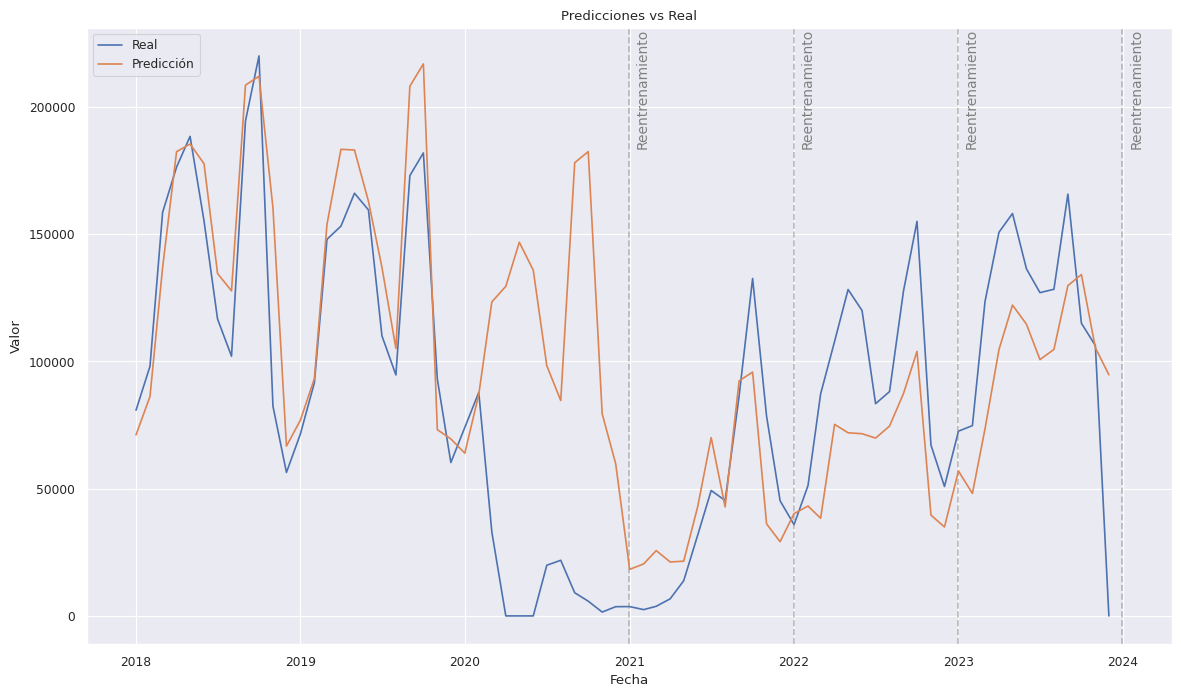

In [87]:
sns.set_theme(style="darkgrid")
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(14, 8))
real_line = sns.lineplot(x=X_val.index, y=y_val, label='Real', ax=ax)
pred_total = pd.Series()
for year, pred in preds.items():
    pred_total = pd.concat([pred_total, pd.Series(pred, index=X_val[X_val.index.year == year].index)])
    if year in retrains:
        ax.axvline(x=pd.to_datetime(f"{year}-12-31", format="%Y-%m-%d"), color='grey', alpha=0.5, linestyle='--')
        ymin, ymax = ax.get_ylim()
        ax.text(pd.to_datetime(f"{year+1}-01-15", format="%Y-%m-%d"), ymax*0.8, f'Reentrenamiento', rotation=90, fontsize=10, color='grey')

sns.lineplot(x=X_val.index, y=pred_total, label='Predicción', ax=ax)
ax.set_title('Predicciones vs Real')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')


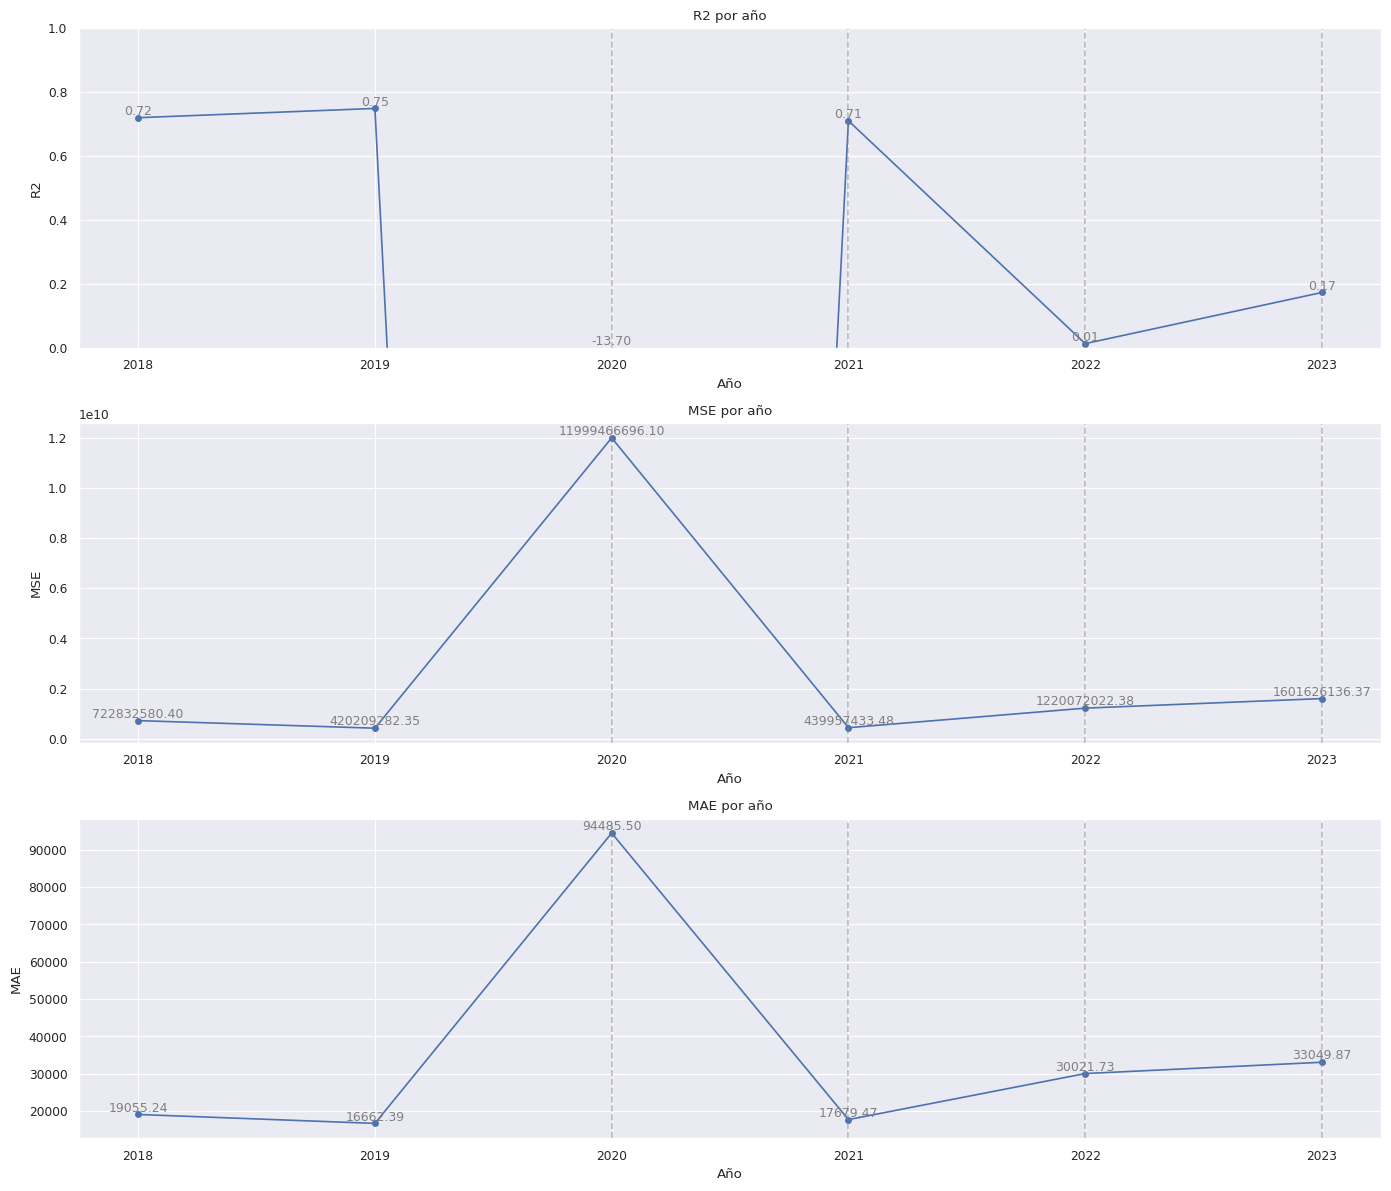

In [96]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12))
sns.lineplot(x=list(measures.keys()), y=[measures[year]['R2'] for year in measures.keys()], ax=ax[0], marker='o', markersize=5, markeredgewidth=0)
ax[0].set_ylim(0, 1)
ax[0].set_title('R2 por año')
ax[0].set_xlabel('Año')
ax[0].set_ylabel('R2')

sns.lineplot(x=list(measures.keys()), y=[measures[year]['MSE'] for year in measures.keys()], ax=ax[1], marker='o', markersize=5, markeredgewidth=0)
ax[1].set_title('MSE por año')
ax[1].set_xlabel('Año')
ax[1].set_ylabel('MSE')

sns.lineplot(x=list(measures.keys()), y=[measures[year]['MAE'] for year in measures.keys()], ax=ax[2], marker='o', markersize=5, markeredgewidth=0)
ax[2].set_title('MAE por año')
ax[2].set_xlabel('Año')
ax[2].set_ylabel('MAE')

for year, measure in measures.items():
    r2, mse, mae = measure['R2'], measure['MSE'], measure['MAE']
    pos_r2, pos_mse, pos_mae = r2, mse, mae
    if r2 < 0:
        pos_r2 = 0
    elif r2 > 1:
        pos_r2 = 1

    ax[0].text(year, pos_r2 , f'{r2:.2f}', ha='center', va='bottom', fontsize=9, color='grey')
    ax[1].text(year, pos_mse, f'{mse:.2f}', ha='center', va='bottom', fontsize=9, color='grey')
    ax[2].text(year, pos_mae, f'{mae:.2f}', ha='center', va='bottom', fontsize=9, color='grey')

    if year in retrains:
        ax[0].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
        ax[1].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
        ax[2].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
fig.tight_layout()
fig.show()


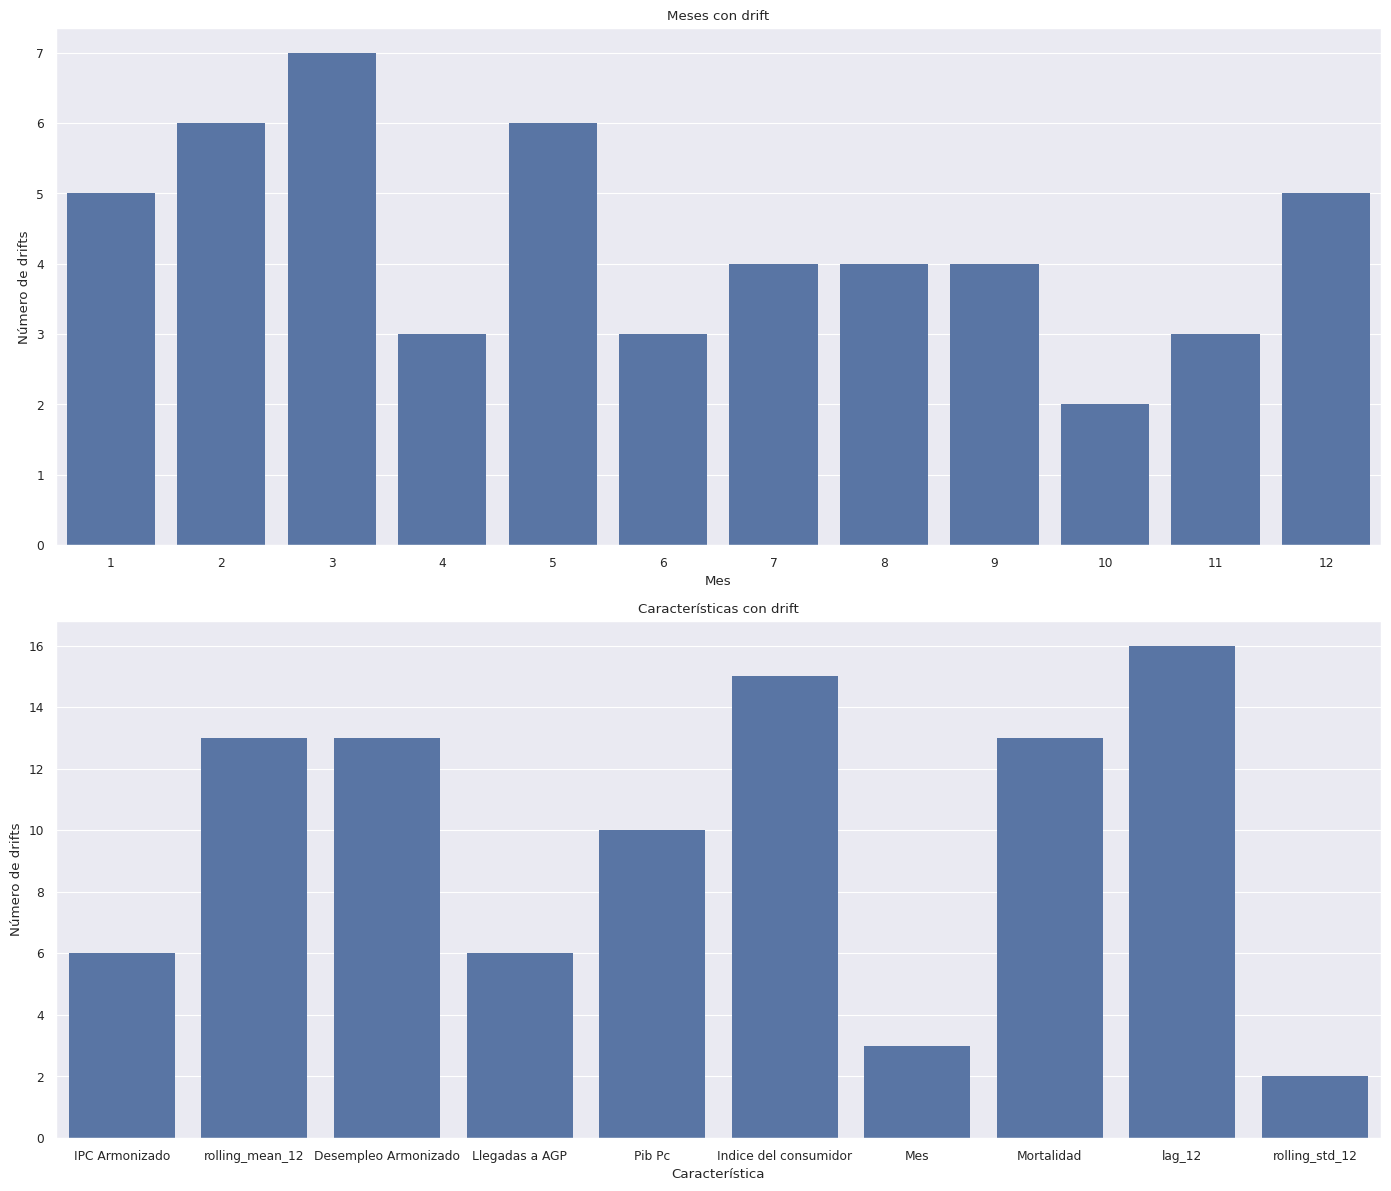

In [97]:
drifting_months = {}
drifting_feats = {}
for year, drift_resumee in details.items():
    for type, values in drift_resumee.items():
        match type:
            case "direct_pvalue_violations" | "diff_pvalue_violations":
                for month in values:
                    drifting_months[month] = drifting_months.get(month, 0) + 1
            case "direct_distance_violations" | "diff_distance_violations":
                for month, feats in values.items():
                    drifting_months[month] = drifting_months.get(month, 0) + 1
                    for feat in feats:
                        drifting_feats[feat] = drifting_feats.get(feat, 0) + 1
            case _ :
                pass

fig, ax = plt.subplots(2, 1, figsize=(14, 12))
sns.barplot(x=list(drifting_months.keys()), y=list(drifting_months.values()), ax=ax[0], linewidth=0)
ax[0].set_title('Meses con drift')
ax[0].set_xlabel('Mes')
ax[0].set_ylabel('Número de drifts')

sns.barplot(x=list(drifting_feats.keys()), y=list(drifting_feats.values()), ax=ax[1], linewidth=0)
ax[1].set_title('Características con drift')
ax[1].set_xlabel('Característica')
ax[1].set_ylabel('Número de drifts')

fig.tight_layout()
fig.show()



# Probando metodología con otros datos

### España

/tmp/ipykernel_3788154/2162233321.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_arrivals[f'lag_{lag}'] = spain_arrivals[spain_target].shift(lag)
/tmp/ipykernel_3788154/2162233321.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_arrivals[f'rolling_mean_{window}'] = spain_arrivals[spain_target].rolling(window=window).mean()
/tmp/ipykernel_3788154/2162233321.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9999385663482819
Validation start date: 2010-01-01 00:00:00
Validation start date: 2011-01-01 00:00:00
Validation start date: 2012-01-01 00:00:00
Validation start date: 2013-01-01 00:00:00
Validation start date: 2014-01-01 00:00:00
Cross-validation results:
            MSE        R2            MAE
0  3.555921e+10  0.735267  133143.914674
1  6.197089e+09  0.948882   61869.320297
2  1.890146e+09  0.982918   35611.217586
3  2.755747e+09  0.976813   43710.523184
4  8.737887e+09  0.925093   76908.619723
Test MSE: 1952859046.7086093
Test R2: 0.9787037039826271
Test MAE: 41142.89380227022
Best hyperparameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 10}
2016
(12, 10)
{'R2': 0.9097522661116874, 'MSE': 5960261153.12764, 'MAE': 66710.04278886685}
No drift detected in year 2016
2017
(12, 10)
{'R2': 0.8811874609259662, 'MSE': 7534126609.52274, 'MAE': 77607.00854182655}
No drift detected in year 201

/tmp/ipykernel_3788154/2162233321.py:90: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred_total = pd.concat([pred_total, pd.Series(pred, index=X_spain_val[X_spain_val.index.year == year].index)])


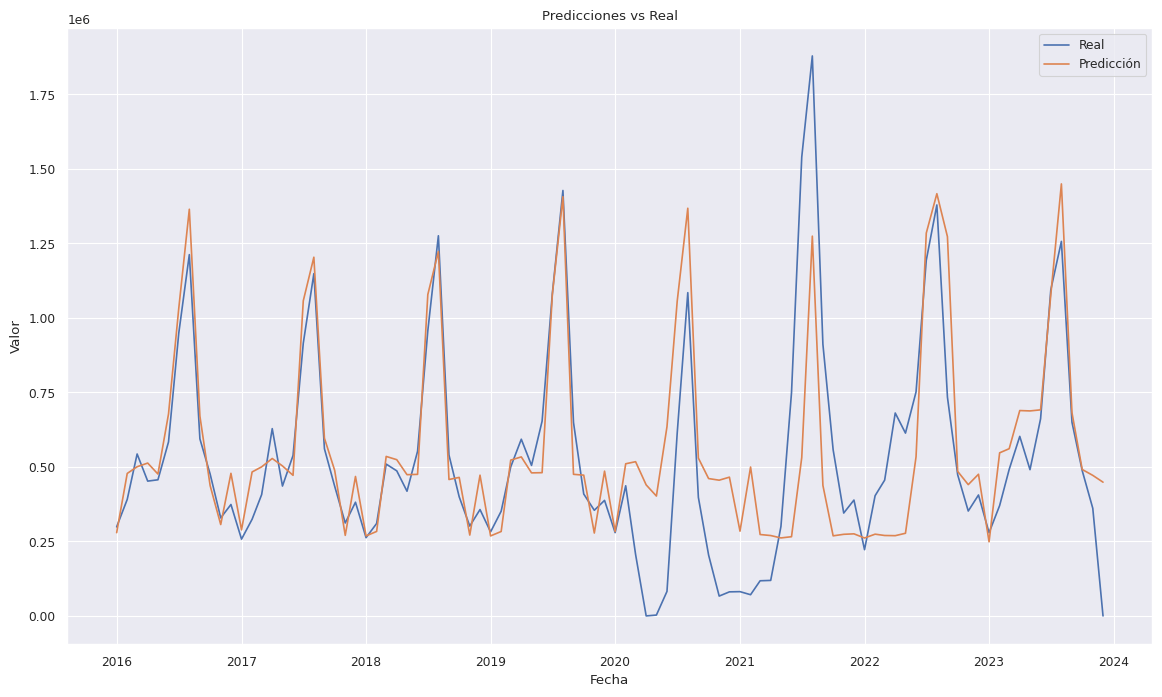

In [91]:
max_pvalue = 0.05
max_distance = 0.9
max_diff_dist = 0.35
max_diff_pval = -0.35

spain_data = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism_espana.csv', sep=";", decimal=".", encoding="utf-8")
spain_data.rename(columns={f"Llegadas a AGP España": 'Llegadas a AGP'}, inplace=True)
spain_data[date_column] = pd.to_datetime(spain_data[date_column])
spain_target = 'España'

spain_data['Mes'] = spain_data[date_column].dt.month
spain_data = spain_data.set_index(spain_data[date_column])
spain_data = spain_data.drop(columns=[date_column])

spain_arrivals = spain_data[[spain_target,f'Llegadas a AGP','Pib Pc','Desempleo Armonizado',
                    'IPC Armonizado', 'Mes', 'Indice del consumidor', 'Mortalidad']]

lag = 12
spain_arrivals[f'lag_{lag}'] = spain_arrivals[spain_target].shift(lag)

for window in [12]:
    spain_arrivals[f'rolling_mean_{window}'] = spain_arrivals[spain_target].rolling(window=window).mean()
    spain_arrivals[f'rolling_std_{window}'] = spain_arrivals[spain_target].rolling(window=window).std()

spain_arrivals = spain_arrivals.dropna()

X_spain_train = split_by_datetime(spain_arrivals,'2009-01-01','2014-12-01')
X_spain_test = split_by_datetime(spain_arrivals,'2015-01-01', '2015-12-01')
X_spain_val = split_by_datetime(spain_arrivals,'2016-01-01', '2023-12-01')

y_spain_train = pd.Series(data=X_spain_train[spain_target], index=X_spain_train.index)
X_spain_train = X_spain_train.drop(spain_target, axis = 1)

y_spain_test = pd.Series(data=X_spain_test[spain_target], index=X_spain_test.index)
X_spain_test = X_spain_test.drop(spain_target, axis = 1)

y_spain_val = pd.Series(data=X_spain_val[spain_target], index=X_spain_val.index)
X_spain_val = X_spain_val.drop(spain_target, axis = 1)

param_distributions = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 600, 1000],
    'max_features': [X_test.shape[1], 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [2, 5, 10],
    'random_state': [11]
}

spain_results_train, model, parameters, test_metrics = rf_grid_search(
    X_train = X_spain_train,
    y_train = y_spain_train,
    X_test = X_spain_test,
    y_test = y_spain_test,
    param_distributions = param_distributions
)

(
    preds_spain,
    measures_spain,
    xais_spain,
    pvalues_spain,
    distances_spain,
    details_spain,
    retrains_spain,
    best_model_spain,
    best_params_spain,
    test_metrics_spain,
) = detect_drift_and_retrain(
    model = model,
    explainer = shap.TreeExplainer(model, X_spain_train),
    X_train = X_spain_train,
    y_train = y_spain_train,
    X_val = X_spain_val,
    y_val = y_spain_val,
    X_test = X_spain_test,
    y_test = y_spain_test,
    param_distributions = param_distributions,
    max_pvalue = max_pvalue,
    max_distance = max_distance,
    max_diff_dist = max_diff_dist,
    max_diff_pval = max_diff_pval
)

sns.set_theme(style="darkgrid")
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(14, 8))
real_line = sns.lineplot(x=X_spain_val.index, y=y_spain_val, label='Real', ax=ax)
pred_total = pd.Series()
for year, pred in preds_spain.items():
    pred_total = pd.concat([pred_total, pd.Series(pred, index=X_spain_val[X_spain_val.index.year == year].index)])
    if year in retrains_spain:
        ax.axvline(x=pd.to_datetime(f"{year}-12-31", format="%Y-%m-%d"), color='grey', alpha=0.5, linestyle='--')
        ymin, ymax = ax.get_ylim()
        ax.text(pd.to_datetime(f"{year+1}-01-15", format="%Y-%m-%d"), ymax*0.8, f'Reentrenamiento', rotation=90, fontsize=10, color='grey')

sns.lineplot(x=X_spain_val.index, y=pred_total, label='Predicción', ax=ax)
ax.set_title('Predicciones vs Real')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
fig.show()

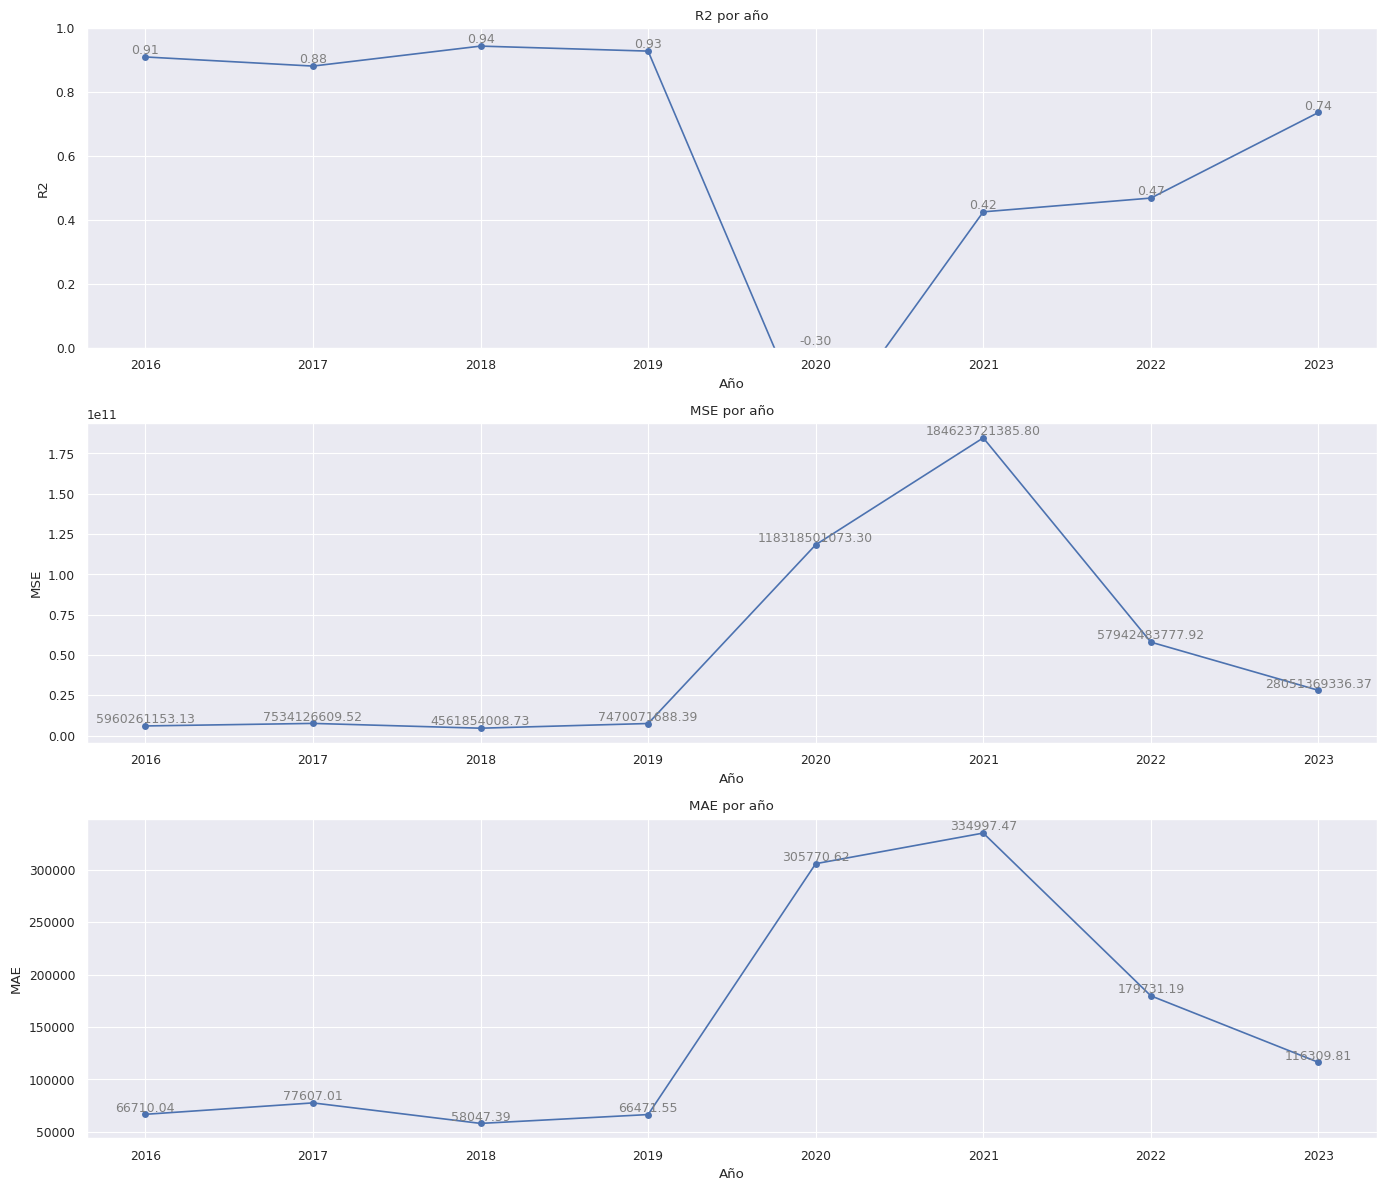

In [98]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12))
sns.lineplot(x=list(measures_spain.keys()), y=[measures_spain[year]['R2'] for year in measures_spain.keys()], ax=ax[0], marker='o', markersize=5, markeredgewidth=0)
ax[0].set_ylim(0, 1)
ax[0].set_title('R2 por año')
ax[0].set_xlabel('Año')
ax[0].set_ylabel('R2')

sns.lineplot(x=list(measures_spain.keys()), y=[measures_spain[year]['MSE'] for year in measures_spain.keys()], ax=ax[1], marker='o', markersize=5, markeredgewidth=0)
ax[1].set_title('MSE por año')
ax[1].set_xlabel('Año')
ax[1].set_ylabel('MSE')

sns.lineplot(x=list(measures_spain.keys()), y=[measures_spain[year]['MAE'] for year in measures_spain.keys()], ax=ax[2], marker='o', markersize=5, markeredgewidth=0)
ax[2].set_title('MAE por año')
ax[2].set_xlabel('Año')
ax[2].set_ylabel('MAE')

for year, measure in measures_spain.items():
    r2, mse, mae = measure['R2'], measure['MSE'], measure['MAE']
    pos_r2, pos_mse, pos_mae = r2, mse, mae
    if r2 < 0:
        pos_r2 = 0
    elif r2 > 1:
        pos_r2 = 1

    ax[0].text(year, pos_r2 , f'{r2:.2f}', ha='center', va='bottom', fontsize=9, color='grey')
    ax[1].text(year, pos_mse, f'{mse:.2f}', ha='center', va='bottom', fontsize=9, color='grey')
    ax[2].text(year, pos_mae, f'{mae:.2f}', ha='center', va='bottom', fontsize=9, color='grey')

    if year in retrains_spain:
        ax[0].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
        ax[1].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
        ax[2].axvline(x=year, color='grey', alpha=0.5, linestyle='--')

fig.tight_layout()
fig.show()

### Reino Unido

/tmp/ipykernel_3788154/3782170788.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_arrivals[f'lag_{lag}'] = uk_arrivals[uk_target].shift(lag)
/tmp/ipykernel_3788154/3782170788.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_arrivals[f'rolling_mean_{window}'] = uk_arrivals[uk_target].rolling(window=window).mean()
/tmp/ipykernel_3788154/3782170788.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9999999998063973
Validation start date: 2010-01-01 00:00:00
Validation start date: 2011-01-01 00:00:00
Validation start date: 2012-01-01 00:00:00
Validation start date: 2013-01-01 00:00:00
Validation start date: 2014-01-01 00:00:00
Cross-validation results:
            MSE        R2           MAE
0  7.570338e+08  0.942456  20894.528166
1  5.354805e+09  0.734081  65508.558631
2  9.049568e+09  0.725061  79759.322725
3  5.586259e+09  0.858498  66443.733885
4  1.624243e+09  0.959339  31860.886389
Test MSE: 3499390133.9874463
Test R2: 0.934059557280136
Test MAE: 47264.37138673952
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 11}
2016
(12, 10)
{'R2': 0.7911318929301159, 'MSE': 12863241703.975859, 'MAE': 96436.40403895643}
No drift detected in year 2016
2017
(12, 10)
{'R2': 0.792534900744595, 'MSE': 12079680334.823526, 'MAE': 83844.2648181038}
No drift detected in year 201

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9999999999999967
Validation start date: 2016-01-01 00:00:00
Validation start date: 2017-01-01 00:00:00
Validation start date: 2018-01-01 00:00:00
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Cross-validation results:
            MSE        R2            MAE
0  8.548747e+09  0.861189   78371.141008
1  6.513438e+09  0.888134   59775.563036
2  3.569183e+09  0.928665   45928.759161
3  1.960163e+09  0.963837   33869.676015
4  8.260886e+10 -5.427214  262729.492492
Test MSE: 4305020269.201795
Test R2: 0.9188787384087158
Test MAE: 54564.357037908776
Best hyperparameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 11}
2021
(12, 10)
{'R2': 0.862073440040595, 'MSE': 2750598810.674891, 'MAE': 32717.494428769245}
Drift detected in year 2021
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {5: ['Pib Pc'], 6: ['Pib Pc']}, 'diff_pvalue_v

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 0.9999999999990205
Validation start date: 2017-01-01 00:00:00
Validation start date: 2018-01-01 00:00:00
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Validation start date: 2021-01-01 00:00:00
Cross-validation results:
            MSE        R2            MAE
0  6.513438e+09  0.888134   59775.563036
1  3.569183e+09  0.928665   45928.759161
2  1.960163e+09  0.963837   33869.676015
3  8.260886e+10 -5.427214  262729.492492
4  2.750599e+09  0.862073   32717.494429
Test MSE: 4155732959.1883144
Test R2: 0.92169182038524
Test MAE: 50263.32852036168
Best hyperparameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 11}
2022
(12, 10)
{'R2': 0.7613749370779974, 'MSE': 15204958445.13971, 'MAE': 101232.64107512054}
Drift detected in year 2022
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {5: ['Pib Pc']}, 'diff_pvalue_violations': [9],

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 1.0
Validation start date: 2018-01-01 00:00:00
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Validation start date: 2021-01-01 00:00:00
Validation start date: 2022-01-01 00:00:00
Cross-validation results:
            MSE        R2            MAE
0  3.569185e+09  0.928665   45928.768579
1  1.960163e+09  0.963837   33869.677100
2  8.260886e+10 -5.427215  262729.496805
3  2.750599e+09  0.862073   32717.497293
4  1.520481e+10  0.761377  101232.393704
Test MSE: 2974624393.419272
Test R2: 0.9439479332349066
Test MAE: 46037.84304692339
Best hyperparameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 11}
2023
(12, 10)
{'R2': 0.6524072528974183, 'MSE': 22677078437.583286, 'MAE': 91732.35073557908}
Drift detected in year 2023
Drifting in:
{'direct_pvalue_violations': [], 'direct_distance_violations': {}, 'diff_pvalue_violations': [8], 'diff_distance_violations

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/juancarlos/Deskt

Best model score: 1.0
Validation start date: 2019-01-01 00:00:00
Validation start date: 2020-01-01 00:00:00
Validation start date: 2021-01-01 00:00:00
Validation start date: 2022-01-01 00:00:00
Validation start date: 2023-01-01 00:00:00
Cross-validation results:
            MSE        R2            MAE
0  1.960163e+09  0.963837   33869.677100
1  8.260886e+10 -5.427215  262729.496805
2  2.750599e+09  0.862073   32717.497293
3  1.520481e+10  0.761377  101232.393704
4  2.267708e+10  0.652407   91732.350736
Test MSE: 4535906320.251637
Test R2: 0.9145280579069338
Test MAE: 57098.92565997017
Best hyperparameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 11}


/tmp/ipykernel_3788154/3782170788.py:91: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred_total = pd.concat([pred_total, pd.Series(pred, index=X_uk_val[X_uk_val.index.year == year].index)])


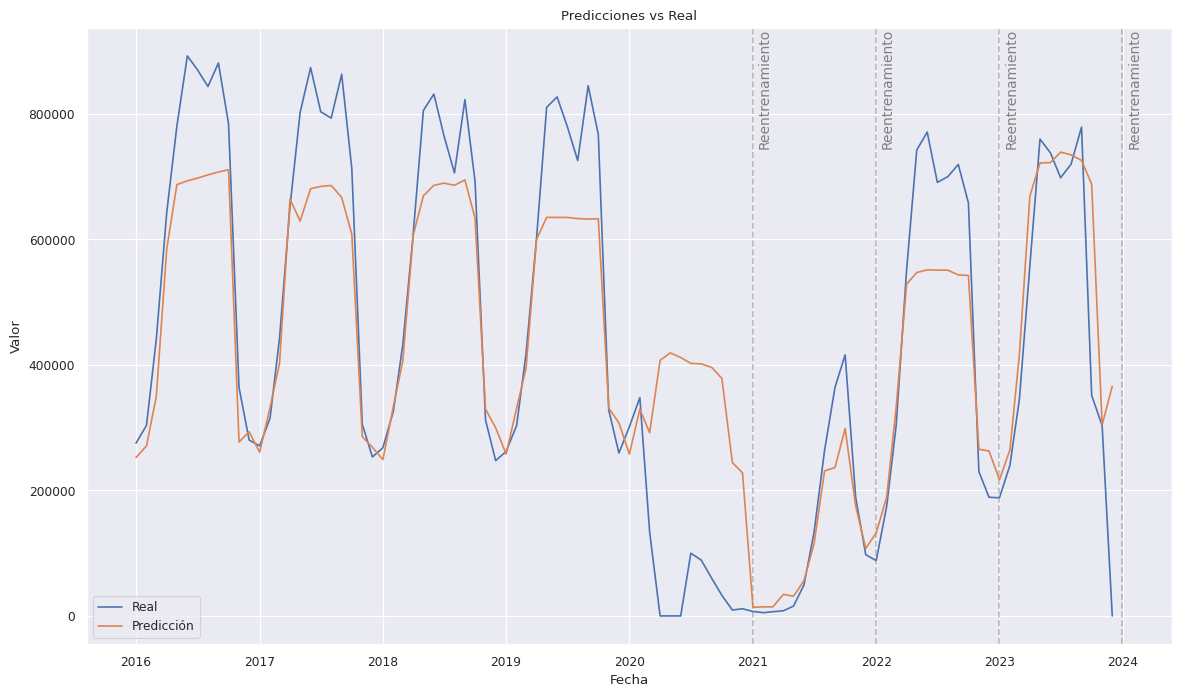

In [95]:
max_pvalue = 0.05
max_distance = 0.95
max_diff_dist = 0.5
max_diff_pval = -0.5


uk_data = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism_uk.csv', sep=";", decimal=".", encoding="utf-8")
uk_data.rename(columns={f"Llegadas a AGP Reino Unido": 'Llegadas a AGP'}, inplace=True)
uk_data[date_column] = pd.to_datetime(uk_data[date_column])
uk_target = 'Reino Unido'

uk_data['Mes'] = uk_data[date_column].dt.month
uk_data = uk_data.set_index(uk_data[date_column])
uk_data = uk_data.drop(columns=[date_column])

uk_arrivals = uk_data[[uk_target,f'Llegadas a AGP','Pib Pc','Desempleo Armonizado',
                    'IPC Armonizado', 'Mes', 'Indice del consumidor', 'Mortalidad']]

lag = 12
uk_arrivals[f'lag_{lag}'] = uk_arrivals[uk_target].shift(lag)

for window in [12]:
    uk_arrivals[f'rolling_mean_{window}'] = uk_arrivals[uk_target].rolling(window=window).mean()
    uk_arrivals[f'rolling_std_{window}'] = uk_arrivals[uk_target].rolling(window=window).std()

uk_arrivals = uk_arrivals.dropna()

X_uk_train = split_by_datetime(uk_arrivals,'2009-01-01','2014-12-01')
X_uk_test = split_by_datetime(uk_arrivals,'2015-01-01', '2015-12-01')
X_uk_val = split_by_datetime(uk_arrivals,'2016-01-01', '2023-12-01')

y_uk_train = pd.Series(data=X_uk_train[uk_target], index=X_uk_train.index)
X_uk_train = X_uk_train.drop(uk_target, axis = 1)

y_uk_test = pd.Series(data=X_uk_test[uk_target], index=X_uk_test.index)
X_uk_test = X_uk_test.drop(uk_target, axis = 1)

y_uk_val = pd.Series(data=X_uk_val[uk_target], index=X_uk_val.index)
X_uk_val = X_uk_val.drop(uk_target, axis = 1)

param_distributions = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 600, 1000],
    'max_features': [X_test.shape[1], 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [2, 5, 10],
    'random_state': [11]
}

uk_results_train, model, parameters, test_metrics = rf_grid_search(
    X_train = X_uk_train,
    y_train = y_uk_train,
    X_test = X_uk_test,
    y_test = y_uk_test,
    param_distributions = param_distributions
)

(
    preds_uk,
    measures_uk,
    xais_uk,
    pvalues_uk,
    distances_uk,
    details_uk,
    retrains_uk,
    best_model_uk,
    best_params_uk,
    test_metrics_uk,
) = detect_drift_and_retrain(
    model = model,
    explainer = shap.TreeExplainer(model, X_uk_train),
    X_train = X_uk_train,
    y_train = y_uk_train,
    X_val = X_uk_val,
    y_val = y_uk_val,
    X_test = X_uk_test,
    y_test = y_uk_test,
    param_distributions = param_distributions,
    max_pvalue = max_pvalue,
    max_distance = max_distance,
    max_diff_dist = max_diff_dist,
    max_diff_pval = max_diff_pval
)

sns.set_theme(style="darkgrid")
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(14, 8))
real_line = sns.lineplot(x=X_uk_val.index, y=y_uk_val, label='Real', ax=ax)
pred_total = pd.Series()
for year, pred in preds_uk.items():
    pred_total = pd.concat([pred_total, pd.Series(pred, index=X_uk_val[X_uk_val.index.year == year].index)])
    if year in retrains_uk:
        ax.axvline(x=pd.to_datetime(f"{year}-12-31", format="%Y-%m-%d"), color='grey', alpha=0.5, linestyle='--')
        ymin, ymax = ax.get_ylim()
        ax.text(pd.to_datetime(f"{year+1}-01-15", format="%Y-%m-%d"), ymax*0.8, f'Reentrenamiento', rotation=90, fontsize=10, color='grey')

sns.lineplot(x=X_uk_val.index, y=pred_total, label='Predicción', ax=ax)
ax.set_title('Predicciones vs Real')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
fig.show()

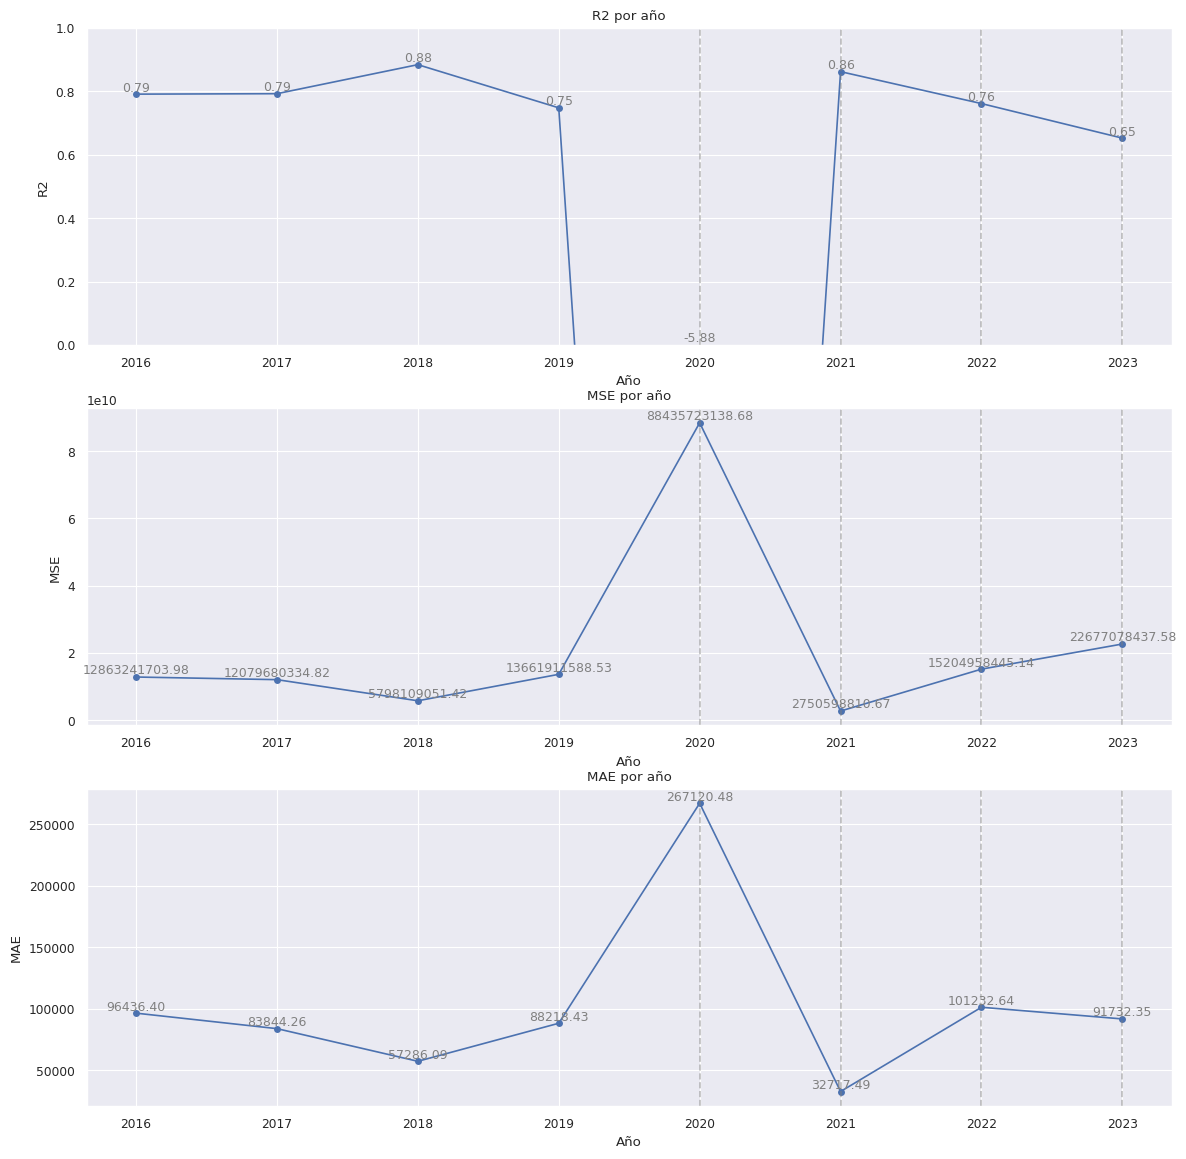

In [101]:
fix, ax = plt.subplots(3, 1, figsize=(14, 14))

sns.lineplot(x=list(measures_uk.keys()), y=[measures_uk[year]['R2'] for year in measures_uk.keys()], ax=ax[0], marker='o', markersize=5, markeredgewidth=0)
ax[0].set_ylim(0, 1)
ax[0].set_title('R2 por año')
ax[0].set_xlabel('Año')
ax[0].set_ylabel('R2')

sns.lineplot(x=list(measures_uk.keys()), y=[measures_uk[year]['MSE'] for year in measures_uk.keys()], ax=ax[1], marker='o', markersize=5, markeredgewidth=0)
ax[1].set_title('MSE por año')
ax[1].set_xlabel('Año')
ax[1].set_ylabel('MSE')

sns.lineplot(x=list(measures_uk.keys()), y=[measures_uk[year]['MAE'] for year in measures_uk.keys()], ax=ax[2], marker='o', markersize=5, markeredgewidth=0)
ax[2].set_title('MAE por año')
ax[2].set_xlabel('Año')
ax[2].set_ylabel('MAE')

for year, measure in measures_uk.items():
    r2, mse, mae = measure['R2'], measure['MSE'], measure['MAE']
    pos_r2, pos_mse, pos_mae = r2, mse, mae
    if r2 < 0:
        pos_r2 = 0
    elif r2 > 1:
        pos_r2 = 1

    ax[0].text(year, pos_r2 , f'{r2:.2f}', ha='center', va='bottom', fontsize=9, color='grey')
    ax[1].text(year, pos_mse, f'{mse:.2f}', ha='center', va='bottom', fontsize=9, color='grey')
    ax[2].text(year, pos_mae, f'{mae:.2f}', ha='center', va='bottom', fontsize=9, color='grey')

    if year in retrains_uk:
        ax[0].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
        ax[1].axvline(x=year, color='grey', alpha=0.5, linestyle='--')
        ax[2].axvline(x=year, color='grey', alpha=0.5, linestyle='--')

fig.tight_layout()
fig.show()
